In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import emcee
import corner
import os
from tqdm import tqdm
import scipy
from scipy.integrate import odeint
import matplotlib.ticker as mticker

# Set font size and formatting options for plots
plt.rcParams['font.size'] = '20'
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,2))

In [2]:
# Define a function to read data from files matching a pattern
def read_data(file_names):
    # Use glob.glob to get a list of file names matching the pattern
    FilenamesList = sorted(glob.glob(file_names))
    # Initialize an empty list to store the data
    data_list = []
    # Loop through each file in the list of matching file names
    for file in FilenamesList:
        # Load the data from the current file using NumPy and append it to the data_list
        u = np.loadtxt(file)
        data_list.append(u)
    # Return the list of data arrays
    return data_list

# Define a function to plot data from a list of datasets
def plot_data(data_list, output_name='full_data', show=False):
    # Define the number of rows and columns for the subplot grid
    nRows = 1
    nCols = 1

    # Create a figure with a grid of subplots based on the specified rows and columns
    fig, ax = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols * 10, nRows * 6))
    data = data_list[0]  # Get the data for the current dataset

    # Plot the data with error bars
    ax.errorbar(data.T[0], data.T[1], data.T[2], linestyle='None', marker='o', color='black', capsize=5)

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Tumor volume (mm³)')

    # Save the figure to a PDF file
    plt.savefig(output_name + '.pdf', bbox_inches='tight', pad_inches=0.02)

    # Show or close the figure based on the 'show' parameter
    if show:
        plt.show()
    else:
        plt.close(fig)

    return

# Define a function that models the forward dynamics of a system.
# It calculates the rates of change for different components of the system.
# Arguments:
# - y: A list containing the current state of the system, typically tumor.
# - time: Current simulation time.
# - parameters: A list of parameters needed for the model [r, K].
def forward_model(y,time, parameters):
    # Unpack parameters for readability
    r, K, g, l = parameters
    tau = [0, 7, 14, 21]
    tumor = r * y[0] * (1 - y[0] / K)
    for i in range(4):
        if time - tau[i] > 0:
            tumor -= g * y[0] * np.exp(-l * (time - tau[i]))
    # Calculate the rate of change for the tumor component based on the given formula
    # tumor = r * y[0] * (1 - y[0] / K) - g * y[0] * np.exp(-l * (time - tau))

    # Return the rate of changes for each component of the system (Just tumor here)
    return tumor

# Define a function to calculate the mean and confidence interval (CI) of a dataset.
# Arguments:
# - data: A list or array containing the data for which the mean and CI should be calculated.
# - confidence: The desired confidence level for the CI (default is 0.95, which corresponds to a 95% CI).
def mean_ci(data, confidence=0.95):
    # Calculate the number of data points in the dataset
    n = len(data)

    # Calculate the mean (average) of the data
    m = np.mean(data)

    # Calculate the standard error of the mean (SE), which measures the variability of the mean
    se = scipy.stats.sem(data)

    # Calculate the half-width of the confidence interval (CI)
    # using the t-distribution and the specified confidence level
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)

    # Return both the mean and the CI half-width
    return m, h

# Define a function to calculate the mean and confidence intervals (CI) for a 2D array of data.
# Arguments:
# - A: A 2D NumPy array containing multiple datasets, where each row represents a dataset.
def get_mean_ci(A):
    # Initialize lists to store means and CI for each dataset
    mean = []
    ci = []

    # Iterate through the rows (datasets) of the 2D array A
    for b in range(A.shape[0]):
        # Calculate the mean and CI for the current dataset using the mean_ci function
        m = mean_ci(A[b], 0.95)

        # Append the mean and CI values to their respective lists
        mean.append(m[0])
        ci.append(m[1])

    # Convert the lists to NumPy arrays for consistency
    ci = np.array(ci)
    mean = np.array(mean)

    # Return a list containing the means and CI for all datasets
    return [mean, ci]

# Define a function to run a stochastic simulation for multiple sets of parameters.
# This function performs a series of simulations, calculates mean and confidence intervals (CI),
# and returns the results for tumor, doxo (Doxorubicin), and tras (Trastuzumab).
# Arguments:
# - D_treat: A list of days when Doxorubicin treatment is administered.
# - T_treat: A list of days when Trastuzumab treatment is administered.
# - parameters: A list of parameter sets, where each set is used for one simulation.
# - data: A 2D NumPy array containing time and tumor data.
def run_stochastic(parameters, data, r=0, k=0):
    create = True  # A flag to determine if new arrays need to be created

    # Iterate through the parameter sets for simulations
    for p in parameters:
        # Solve the forward model for the current parameter set and treatments
        times = np.arange(data[:, 0][0], data[:, 0][-1] + 0.5 * 1, 1)
        solution = odeint(forward_model, t=times, y0=p[-2], args=tuple([np.concatenate(([r, k], p[:-2]))]))


        # If creating arrays for the first time, initialize them with the results
        if create:
            tumor = solution[:, 0].reshape(len(solution[:, 0]), 1)
            create = False
        else:
            # Append the results to existing arrays
            tumor = np.append(tumor, solution[:, 0].reshape(len(solution[:, 0]), 1), 1)

    # Calculate the mean and confidence intervals (CI) for the tumor, doxo, and tras datasets
    tumor_mean, tumor_ci = get_mean_ci(tumor)

    # Return the means and CIs for tumor, doxo, and tras as a list of lists
    return [[tumor_mean, tumor_ci]]

# Define a function to calculate the logarithm of the prior probability for a given parameter set.
# This function checks whether each parameter falls within specified bounds and assigns a prior probability.
# Arguments:
# - theta: A list of parameter values to be evaluated.
# - l_bound: A list of lower bounds for each parameter.
# - u_bound: A list of upper bounds for each parameter.
def log_prior(theta, l_bound, u_bound):
    # Iterate through lower bounds (l_bound), parameter values (theta), and upper bounds (u_bound)
    for l, p, u in zip(l_bound, theta, u_bound):
        # If any parameter is outside its specified bounds, return negative infinity (log(0))
        if not (l < p < u):
            return -np.inf

    # If all parameters are within their bounds, return a prior probability of 0.0 (log(1))
    return 0.0

# Define a function to calculate the logarithm of the joint probability (prior + likelihood) for a given parameter set.
# This function combines the prior probability and likelihood functions to calculate the joint probability.
# Arguments:
# - theta: A list of parameter values to be evaluated.
# - times: The time data used in the likelihood calculation.
# - y: The observed data used in the likelihood calculation.
# - l_bound: A list of lower bounds for each parameter.
# - u_bound: A list of upper bounds for each parameter.
def log_probability(theta, y, l_bound, u_bound, r, k):
    # Calculate the logarithm of the prior probability for the given parameter set and bounds
    lp = log_prior(theta, l_bound, u_bound)

    # If the prior probability is not finite (e.g., outside of specified bounds), return negative infinity (log(0))
    if not np.isfinite(lp):
        return -np.inf

    # Calculate the joint probability as the sum of the logarithm of the prior and likelihood probabilities
    return lp + log_likelihood(theta, y, r, k)

# Define a function to calculate the logarithm of the likelihood function for a given set of parameters.
# This function evaluates the likelihood of the observed data under the given parameter values.
# Arguments:
# - theta: A list of parameter values used for the simulations.
# - y: A list of datasets, each containing time and observed data.
def log_likelihood(theta, y, r, k):
    ll = 0  # Initialize the log-likelihood

    # Calculate the variance from the last element of the parameter list
    variance = theta[-1] ** 2

    # Determine the common time values to be used for simulations
    times = np.arange(y[0][:, 0][0], y[0][:, 0][-1] + 0.5 * 1, 1)

    # Find the position indices where times intersect with the observed data's time values
    position = np.intersect1d(times, y[0][:, 0], return_indices=True)[1]

    # Loop through the datasets, each with its specific treatment and data
    for i in range(len(y)):
        data = y[i]

        # Simulate the forward model for the current dataset and parameter set
        solution = odeint(forward_model, t=times, y0=theta[-2], args=tuple([np.concatenate(([r, k], theta[:-2]))]))

        # Calculate the contribution to the log-likelihood for this dataset
        ll += -0.5 * np.sum((data[:, 1] - solution[position].reshape(data[:, 1].shape)) ** 2 / variance + np.log(2 * np.pi) + np.log(variance))

    # Return the total log-likelihood for all datasets
    return ll

# Define a function to create and display a corner plot of parameter samples.
# A corner plot displays the correlations and probability distributions of parameter samples.
# Arguments:
# - flat_samples: 2D array of flattened parameter samples from the MCMC chain.
# - labels: List of parameter names to label the plot axes.
# - scn: Name or identifier for the plot, used in the saved file name.
# - show: Boolean flag indicating whether the plot should be displayed (default is True).
# - save: Boolean flag indicating whether the plot should be saved as an image file (default is False).
# - fontsize: Font size for text in the plot (default is '14').
def plot_corner(flat_samples, labels, scn='mouse', show=True, save=False, fontsize='14'):
    # Set the font size for the plot
    plt.rcParams['font.size'] = fontsize

    # Check if the plot should be displayed or saved, and return if neither is requested
    if not show and not save:
        return

    # Create a corner plot using the flat parameter samples and label the axes
    fig = corner.corner(flat_samples, labels=labels)

    # Save the plot as an image file with the specified name
    if save:
        plt.savefig('corner_' + scn + '.jpeg', bbox_inches='tight', pad_inches=0.02, dpi=150)

    # Display the plot if the 'show' flag is set to True; otherwise, close the plot
    if show:
        plt.show()
    else:
        plt.close()

    return

# Calculate Pearson Correlation Coefficient (PCC) between two arrays x and y
def pcc(x, y):
    # Calculate the covariance between x and y
    sxy = np.sum((x - x.mean()) * (y - y.mean())) / x.shape[0]

    # Calculate the Pearson Correlation Coefficient (PCC)
    # by dividing the covariance by the product of the standard deviations of x and y
    rho = sxy / (np.std(x) * np.std(y))

    return rho

# Calculate Concordance Correlation Coefficient (CCC) between two arrays x and y
def ccc(x, y):
    # Calculate the covariance between x and y
    sxy = np.sum((x - x.mean()) * (y - y.mean())) / x.shape[0]

    # Calculate the Concordance Correlation Coefficient (CCC)
    # by dividing 2 times the covariance by the sum of variances of x and y
    # and the square of the mean difference between x and y
    rhoc = 2 * sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)

    return rhoc

# Calculate the Normalized Root Mean Square Error (NRMSE) between two arrays: actual and predicted
def nrmse(actual, pred):
    # Convert the input arrays to NumPy arrays
    actual, pred = np.array(actual), np.array(pred)

    # Calculate the Root Mean Square Error (RMSE) between actual and predicted values
    rmse = np.sqrt(np.sum((actual - pred)**2) / len(actual))

    # Calculate the NRMSE by dividing RMSE by the mean of the actual values and multiplying by 100
    nrmse = rmse / np.mean(actual) * 100

    return nrmse

# Calculate the Mean Absolute Percentage Error (MAPE) between two arrays: actual and predicted
def mape(actual, pred):
    # Convert the input arrays to NumPy arrays
    actual, pred = np.array(actual), np.array(pred)

    # Calculate the absolute percentage error for each element and take the mean
    mape = np.mean(np.abs((actual - pred) / actual)) * 100

    return mape

# Define a function to plot the full solution for different treatments and data.
# This function generates subplots for each dataset and overlays the model predictions.
# Arguments:
# - data_list: List of data arrays for different treatment scenarios.
# - flat_samples: 2D array of parameter samples from the MCMC chain.
# - size: Number of samples to use (default is 50).
# - output_name: Name of the output file (default is 'solution').
# - show: Boolean flag indicating whether the plot should be displayed (default is True).
# - save: Boolean flag indicating whether the plot should be saved as an image file (default is True).
def plot_full_solution(data_list, flat_samples, r=0, k=0, size=50, output_name='solution', show=True, save=True):
    # Select a random subset of parameter samples
    if size < len(flat_samples):
        inds = np.random.randint(len(flat_samples), size=size)
    else:
        inds = np.random.randint(len(flat_samples), size=len(flat_samples))
    parameters = flat_samples[inds]

    # Find the position indices where times intersect with the observed data's time values
    times = np.arange(data_list[0][:,0][0],data_list[0][:,0][-1] + 0.5*1,1)
    position = np.intersect1d(times, data_list[0][:, 0], return_indices=True)[1]

    # Set the number of rows and columns for subplot arrangement
    nRows = 1
    nCols = 1

    # Create a figure with subplots
    fig, ax = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols * 10, nRows * 6))

    dataf = data_list[0]

    # Customize subplot appearance based on the dataset scenario
    solution = run_stochastic(parameters, dataf, r, k)
    ax.fill_between(times, solution[0][0]-solution[0][1], solution[0][0]+solution[0][1], alpha=0.25, color='magenta')
    ax.plot(times, solution[0][0]-solution[0][1], linewidth=2, linestyle="--",color='magenta')
    ax.plot(times, solution[0][0]+solution[0][1], linewidth=2, linestyle="--",color='magenta')
    # Calculate PCC, CCC, MAPE, and NRMSE using the solution
    pccV = pcc(dataf[:,1],solution[0][0][position])
    cccV = ccc(dataf[:,1],solution[0][0][position])
    mapeV = mape(dataf[:,1],solution[0][0][position])
    nrmseV = nrmse(dataf[:,1],solution[0][0][position])
    ax.text(0.05,.8,'CCC/PCC = {:.2f}/{:.2f}\nMAPE = {:.2f}%\nNRMSE = {:.2f}'.format(cccV,pccV,mapeV,nrmseV),horizontalalignment='left',transform=ax.transAxes)

    # Add error bars to the subplot for data points
    ax.errorbar(dataf.T[0], dataf.T[1], dataf.T[2], linestyle='None', marker='o', color='black', capsize=5)

    # Set limits, labels, and ticks for the subplot
    #ax.set_xlim((0, 72))
    #ax.set_ylim((0, 3000))
    #ax.set_xticks(np.arange(0, 73, step=12))
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Tumor volume (mm³)')

    # Save the plot as an image file with the specified name
    if save:
        plt.savefig(output_name + '.pdf', bbox_inches='tight', pad_inches=0.02)

        # Show or close the figure based on the 'show' parameter
    if show:
        plt.show()
    else:
        plt.close(fig)

    return



def plot_all_solution(data_list, flat_samples, r=0, k=0, size=50, output_name='solution', show=True, save=True):
    # Select a random subset of parameter samples
    if size < len(flat_samples):
        inds = np.random.randint(len(flat_samples), size=size)
    else:
        inds = np.random.randint(len(flat_samples), size=len(flat_samples))
    parameters = flat_samples[inds]

    # Find the position indices where times intersect with the observed data's time values
    times = np.arange(data_list[0][:,0][0],data_list[0][:,0][-1] + 0.5*1,1)
    position = np.intersect1d(times, data_list[0][:, 0], return_indices=True)[1]

    # Set the number of rows and columns for subplot arrangement
    nRows = 1
    nCols = 1

    # Create a figure with subplots
    fig, ax = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols * 10, nRows * 6))

    dataf = data_list[0]

    # Customize subplot appearance based on the dataset scenario
    solution = run_stochastic(parameters, dataf, r, k)
    ax.fill_between(times, solution[0][0]-solution[0][1], solution[0][0]+solution[0][1], alpha=0.25, color='magenta')
    ax.plot(times, solution[0][0]-solution[0][1], linewidth=2, linestyle="--",color='magenta')
    ax.plot(times, solution[0][0]+solution[0][1], linewidth=2, linestyle="--",color='magenta')
    # Calculate PCC, CCC, MAPE, and NRMSE using the solution
    pccV = pcc(dataf[:,1],solution[0][0][position])
    cccV = ccc(dataf[:,1],solution[0][0][position])
    mapeV = mape(dataf[:,1],solution[0][0][position])
    nrmseV = nrmse(dataf[:,1],solution[0][0][position])
    ax.text(0.05,.8,'CCC/PCC = {:.2f}/{:.2f}\nMAPE = {:.2f}%\nNRMSE = {:.2f}'.format(cccV,pccV,mapeV,nrmseV),horizontalalignment='left',transform=ax.transAxes)

    # Add error bars to the subplot for data points
    ax.errorbar(dataf.T[0], dataf.T[1], dataf.T[2], linestyle='None', marker='o', color='black', capsize=5)

    # Set limits, labels, and ticks for the subplot
    #ax.set_xlim((0, 72))
    #ax.set_ylim((0, 3000))
    #ax.set_xticks(np.arange(0, 73, step=12))
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Tumor volume (mm³)')

    # Save the plot as an image file with the specified name
    if save:
        plt.savefig(output_name + '.pdf', bbox_inches='tight', pad_inches=0.02)

        # Show or close the figure based on the 'show' parameter
    if show:
        plt.show()
    else:
        plt.close(fig)

    return





# Plot chains of samples from the MCMC calibration
def plot_chain(samples, labels, scn='calibration', show=True, save=True, fontsize='14'):
    # Set the font size for the plot
    plt.rcParams['font.size'] = fontsize

    # Check if the plot should be displayed or saved
    if not show and not save:
        return

    # Determine the number of dimensions in the samples
    ndim = len(samples[0][0])

    # Check if the number of labels matches the number of dimensions
    if len(labels) == ndim:
        nRows = 3
        nCols = int(np.ceil(ndim / nRows))
        fig, axes = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols * 11, nRows * 5))
        axes.shape = (nRows * nCols)

        # Plot the chains for each parameter
        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)
            ax.xaxis.set_major_formatter(formatter)

        # Set the x-axis label and remove any unused subplots
        axes[-1].set_xlabel("Step Number")
        for i in range(ndim, nRows * nCols):
            fig.delaxes(axes[i])

        # Save the plot as an image if specified
        if save:
            plt.savefig('chains_' + scn + '.jpeg', bbox_inches='tight', pad_inches=0.02, dpi=150)

        # Display the plot if specified
        if show:
            plt.show()
        else:
            plt.close()
    else:
        print('Incorrect labels')  # If the number of labels doesn't match the dimensions, print an error message

    return

15120-TG7_full_G05-Pac+Carbo_1wk.txt
241.5666666666667


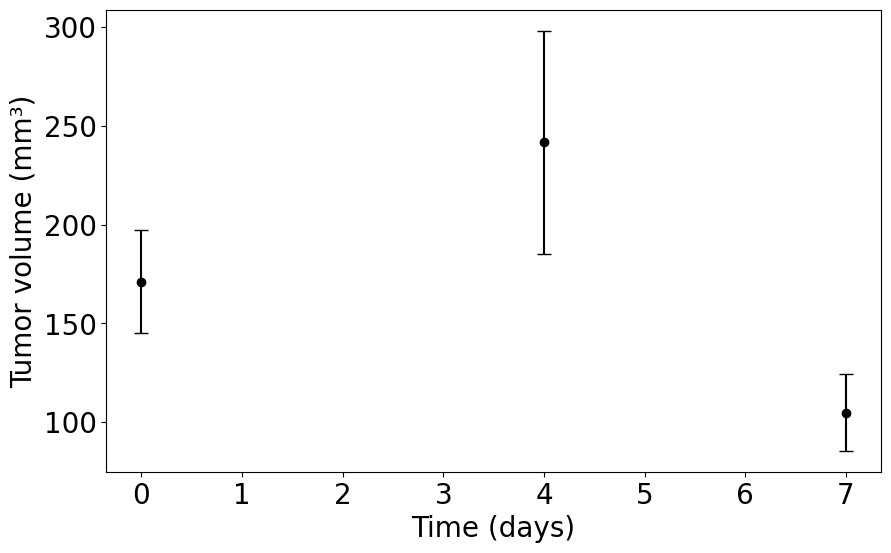

2277-R1TG9_full_G05-Pac+Carbo_1wk.txt
177.86666666666667


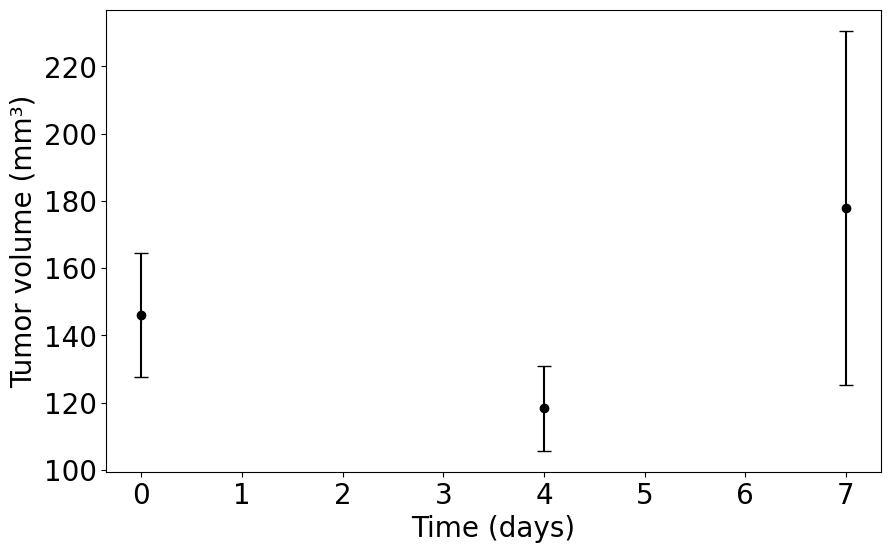

3204-R3TG5_full_G05-Pac+Carbo_1wk.txt
298.7


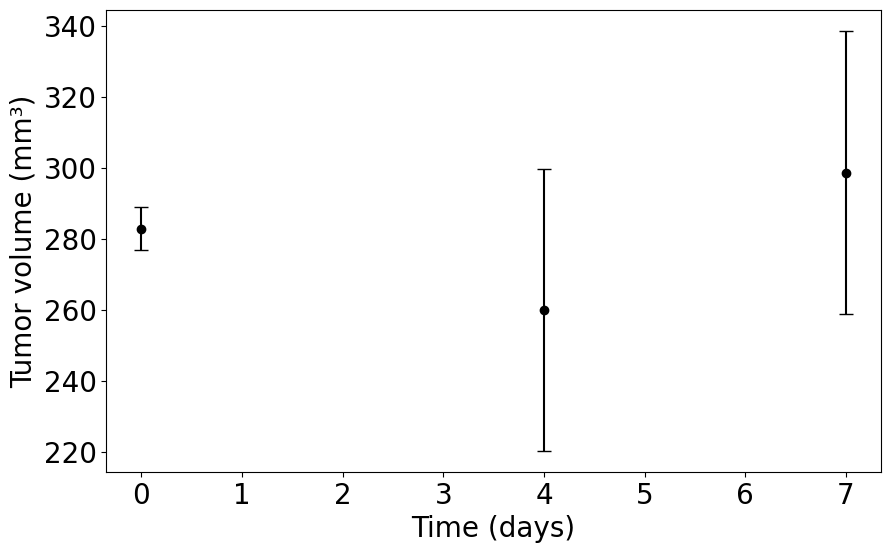

4849-R1TG15_full_G05-Pac+Carbo_1wk.txt
298.8


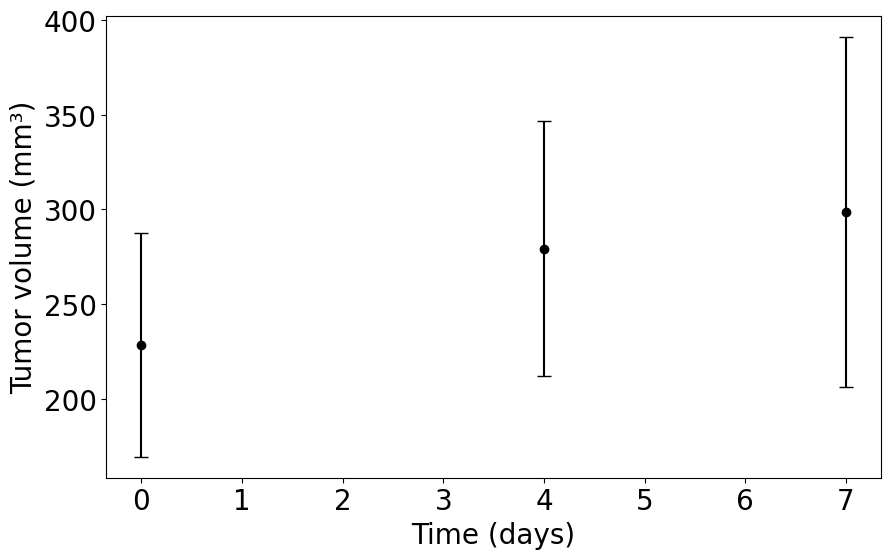

4913-R3TG10_full_G05-Pac+Carbo_1wk.txt
252.9


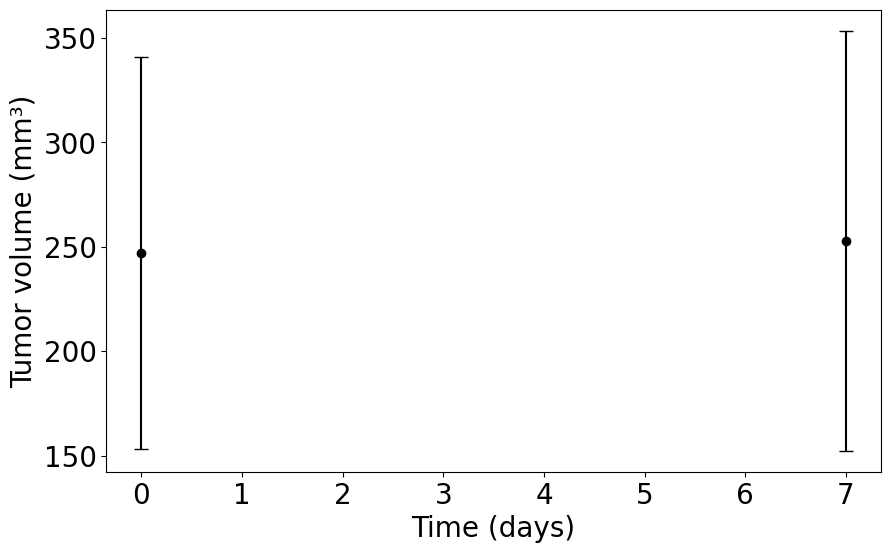

BRA45-R2TG8_Repeat_full_G05-Pac+Carbo_1wk.txt
215.80000000000004


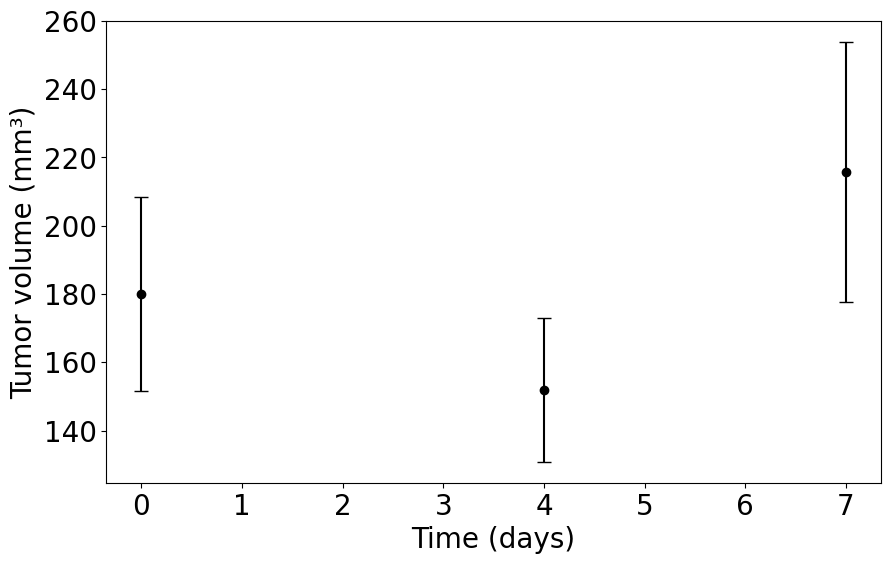

HCI-034-TG11_Repeat_full_G05-Pac+Carbo_1wk.txt
251.73333333333335


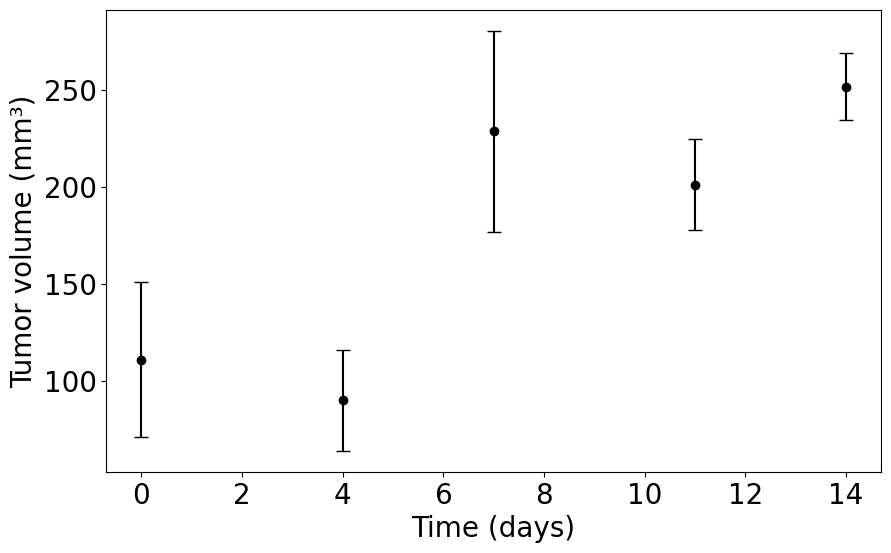

15120-TG7_full_G06-Pac+Carbo_4wk.txt
244.96666666666667


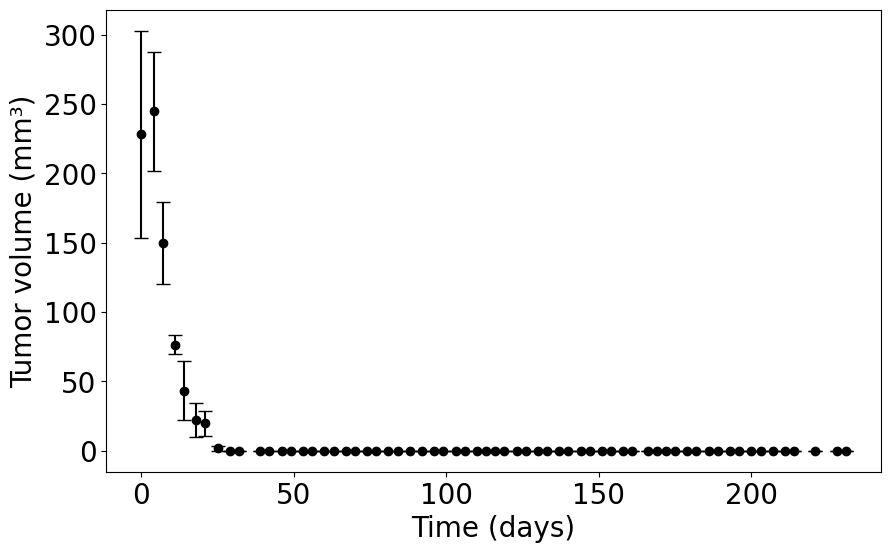

2277-R1TG9_full_G06-Pac+Carbo_4wk.txt
262.5


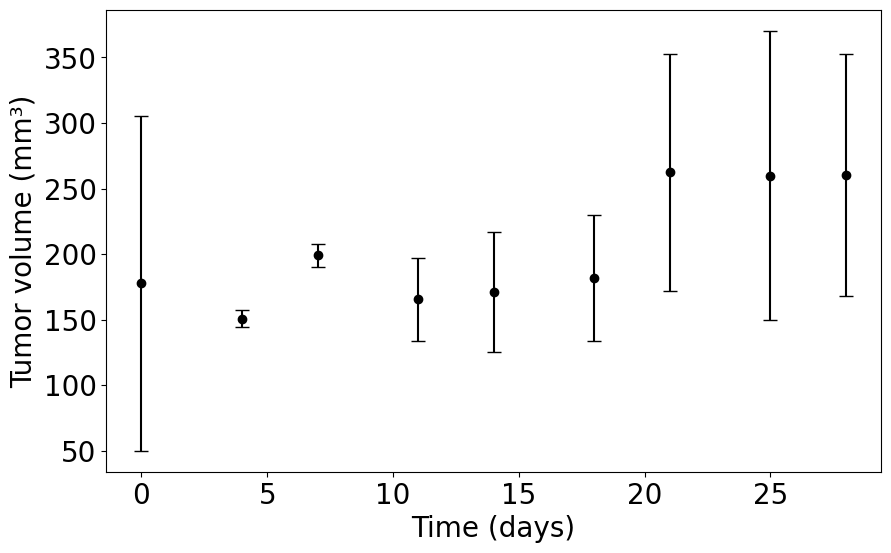

3204-R3TG5_full_G06-Pac+Carbo_4wk.txt
273.40000000000003


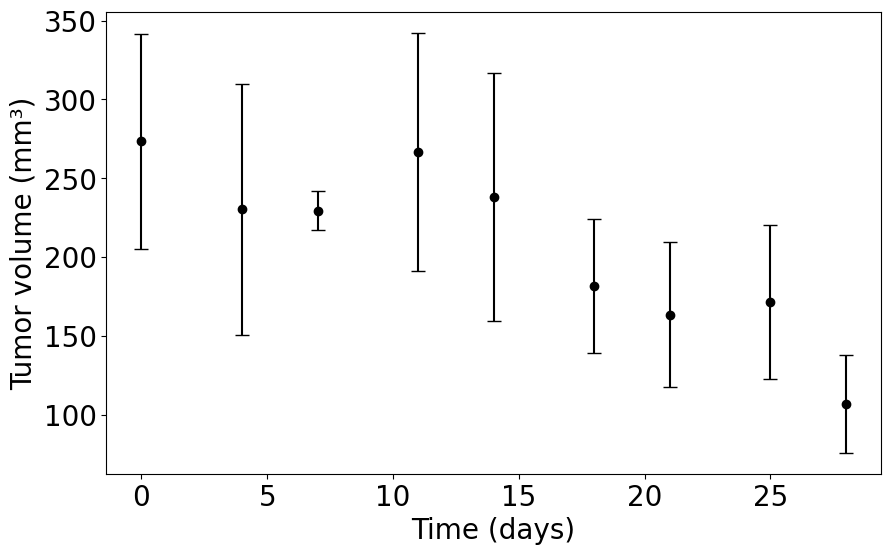

4849-R1TG15_full_G06-Pac+Carbo_4wk.txt
493.7666666666667


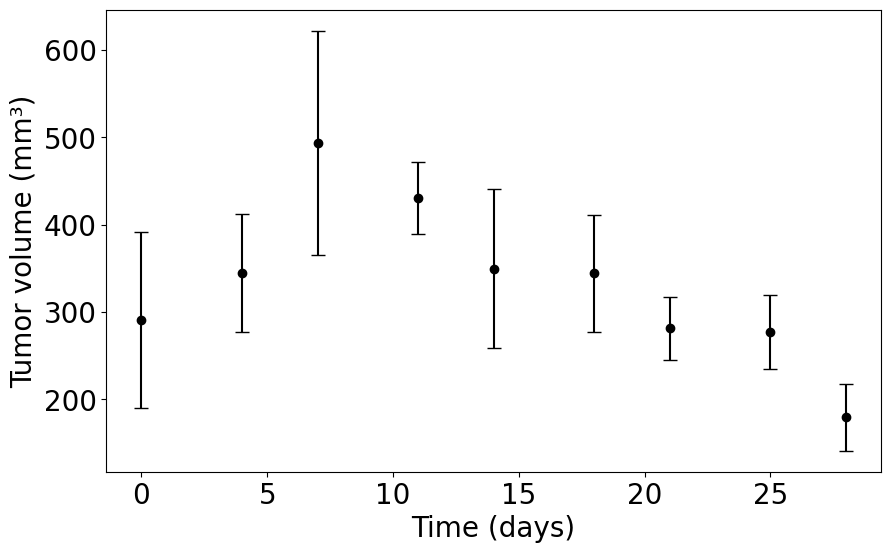

4913-R3TG10_full_G06-Pac+Carbo_4wk.txt
208.5666666666667


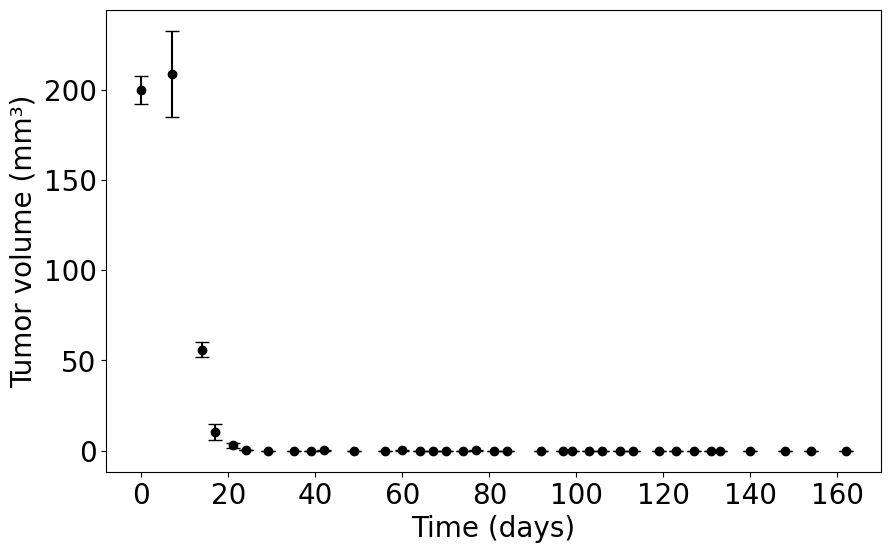

BRA45-R2TG8_Repeat_full_G06-Pac+Carbo_4wk.txt
214.36666666666667


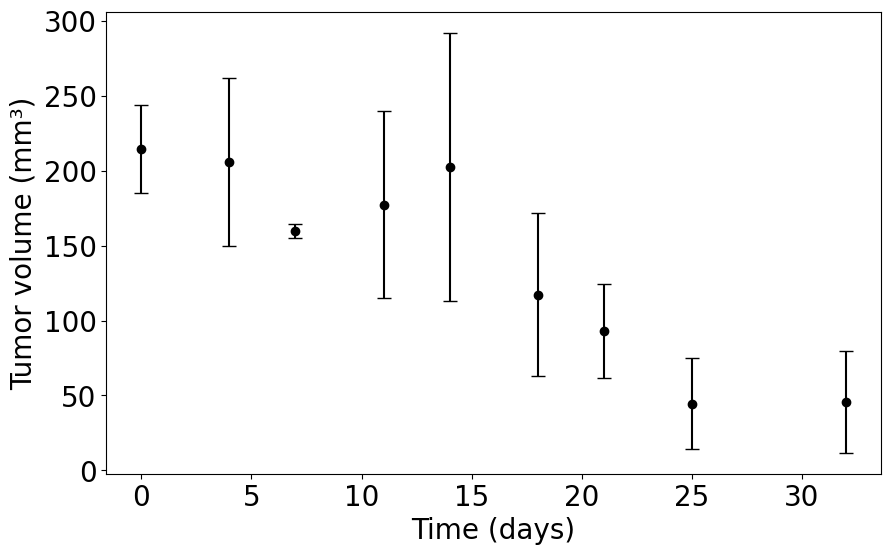

HCI-034-TG11_Repeat_full_G06-Pac+Carbo_4wk.txt
337.8333333333333


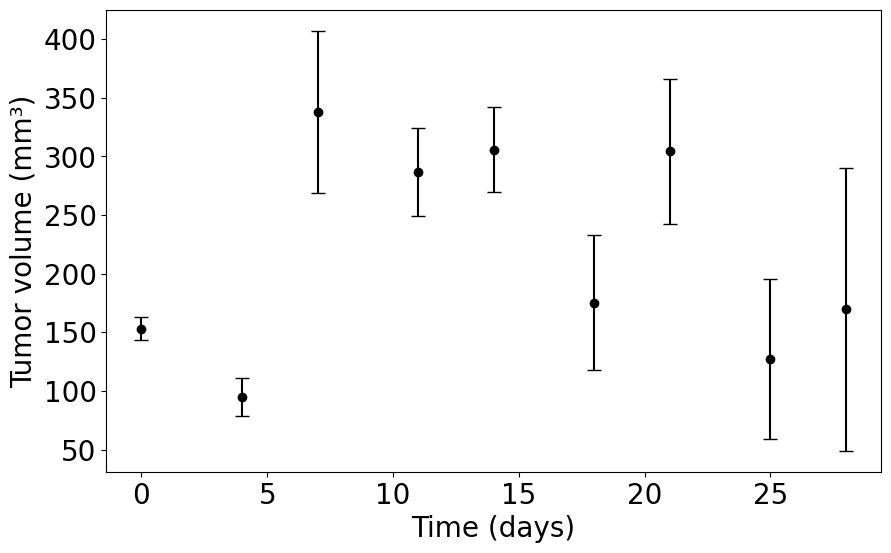

In [5]:
Week_Treatment_Files = sorted(glob.glob('*+Carbo_1wk.txt'))
for file_name in Week_Treatment_Files:
    print(file_name)
    data = read_data(file_name)
    print(max(data[0][:,1]))
    plot_data(data, show=True)
    
Treatment_Files = sorted(glob.glob('*+Carbo_4wk.txt'))
for file_name in Treatment_Files:
    print(file_name)
    data = read_data(file_name)
    print(max(data[0][:,1]))
    plot_data(data, show=True)


15120-TG7_full_G05-Pac+Carbo_1wk.txt
15120-TG7_full_G06-Pac+Carbo_4wk.txt


100%|████████████████████████████████████| 20000/20000 [02:55<00:00, 113.98it/s]


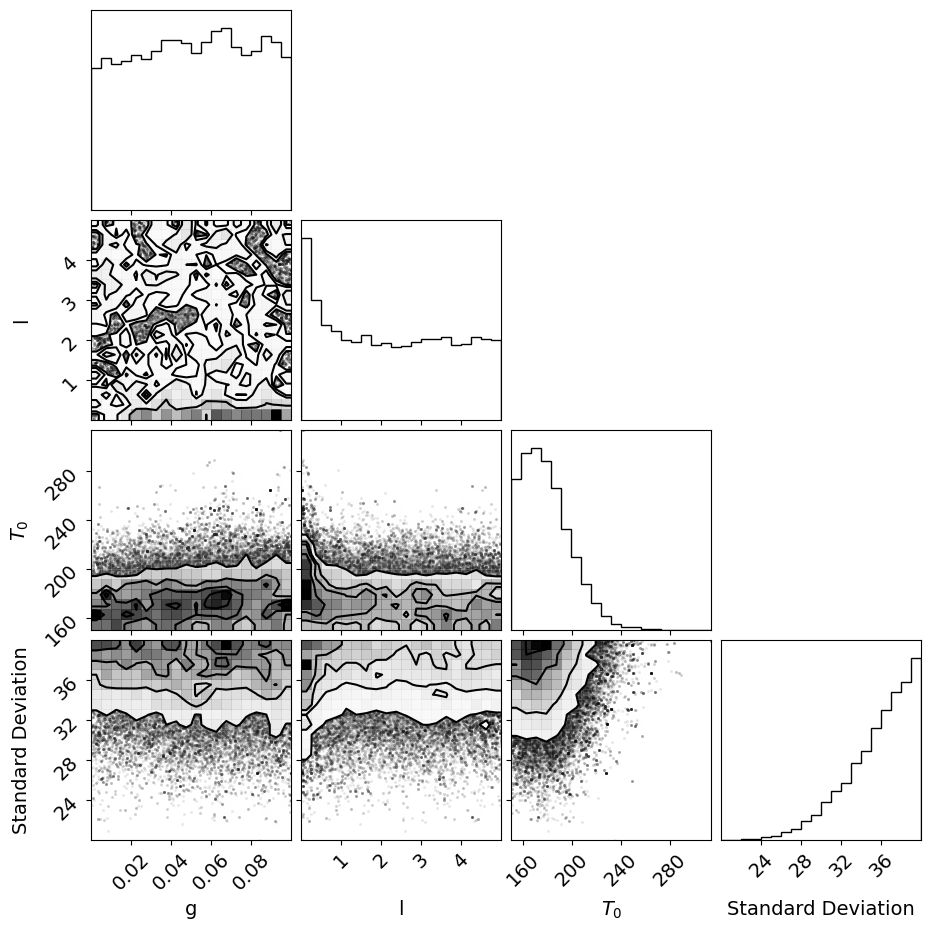

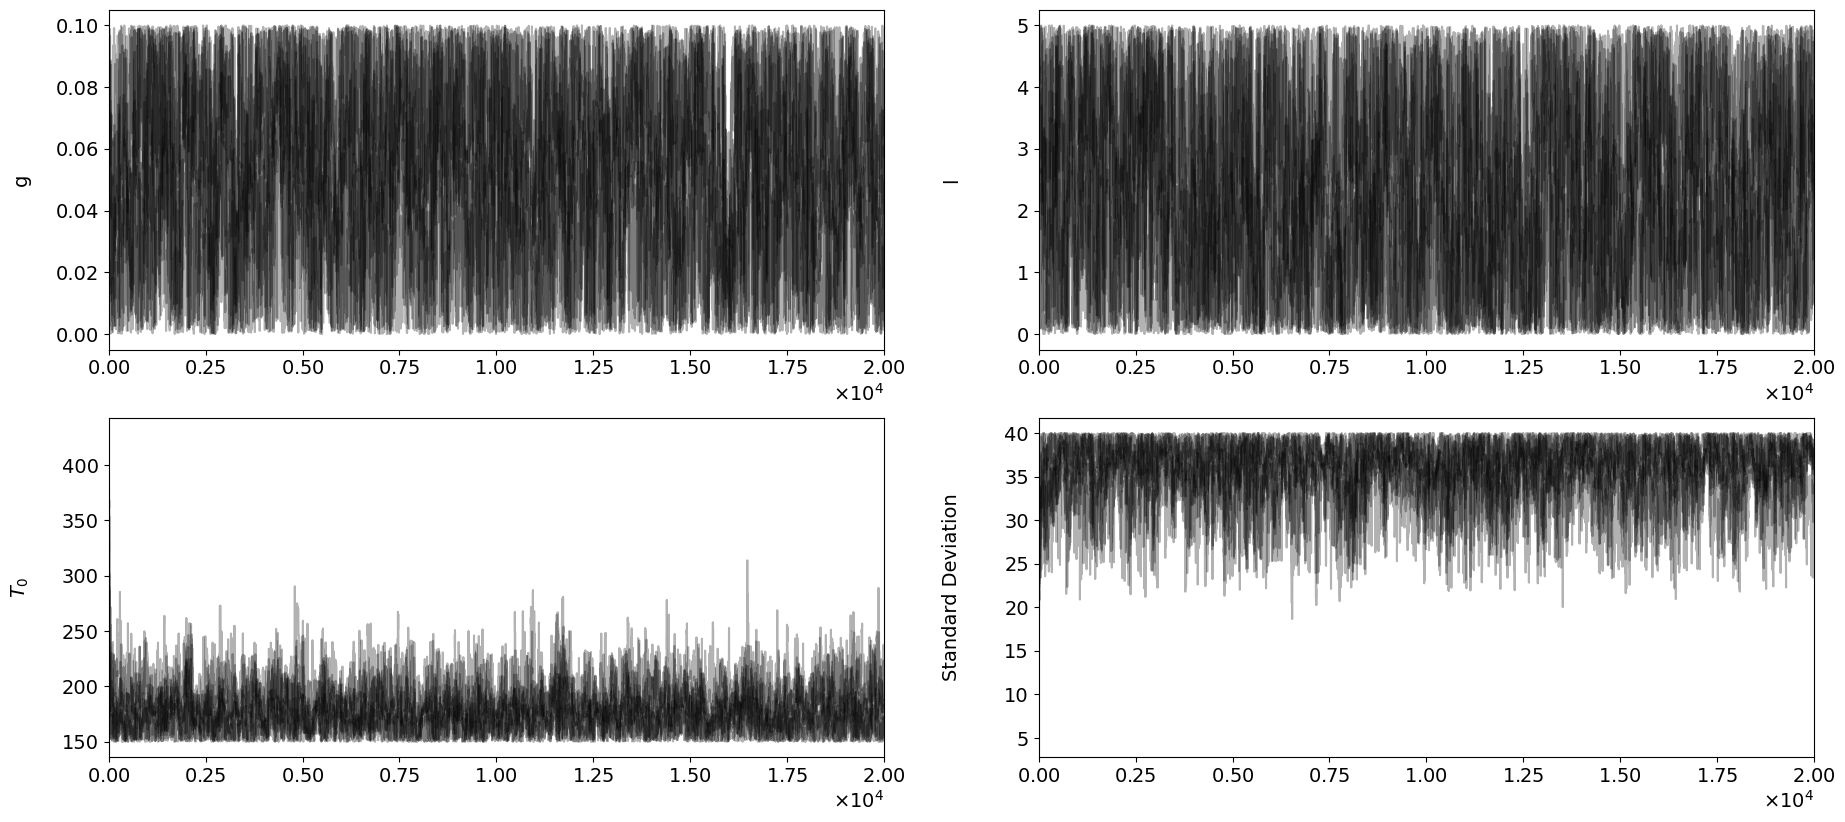

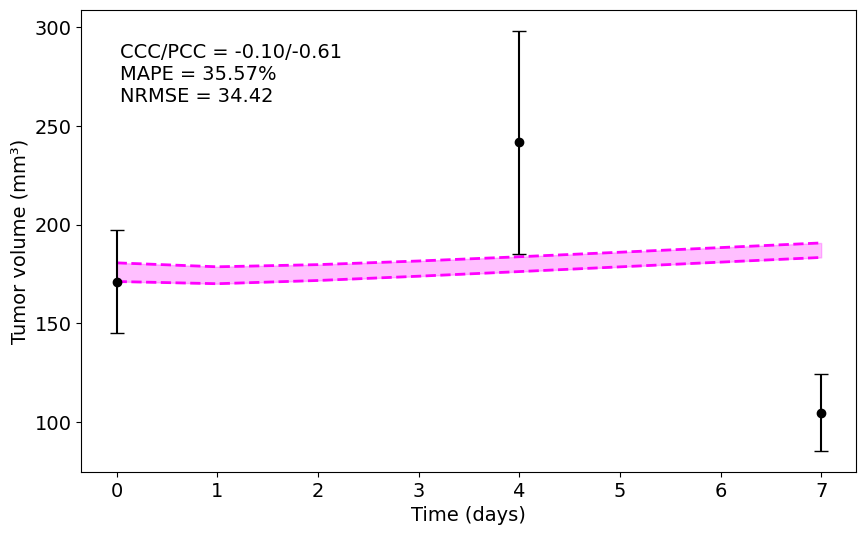

15120-TG7_full_G05-Pac+Carbo_1wk.txt


/var/folders/mb/db4t4c7x2b51v75ygss9ww1h0000gn/T/ipykernel_23476/2751737809.py:282: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - pred) / actual)) * 100


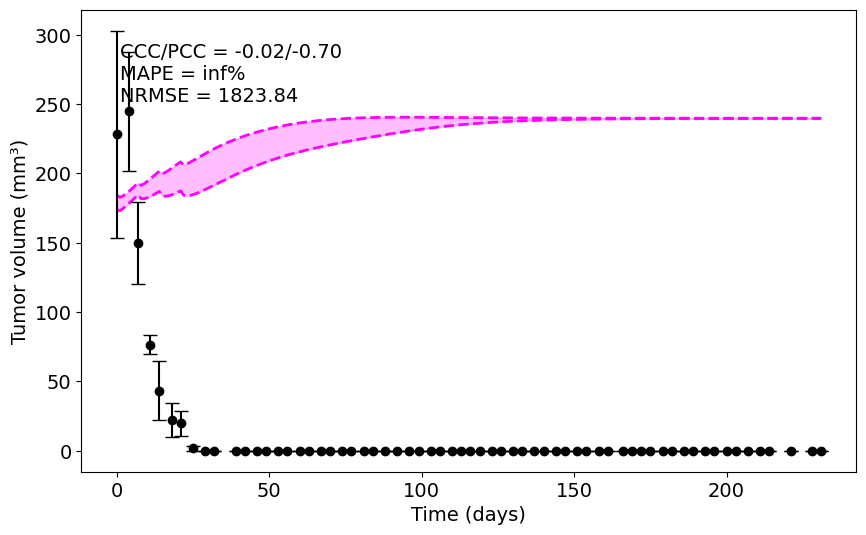

15120-TG7_full_G05-Pac+Carbo_1wk.txt
2277-R1TG9_full_G05-Pac+Carbo_1wk.txt
2277-R1TG9_full_G06-Pac+Carbo_4wk.txt


100%|████████████████████████████████████| 20000/20000 [02:40<00:00, 124.51it/s]


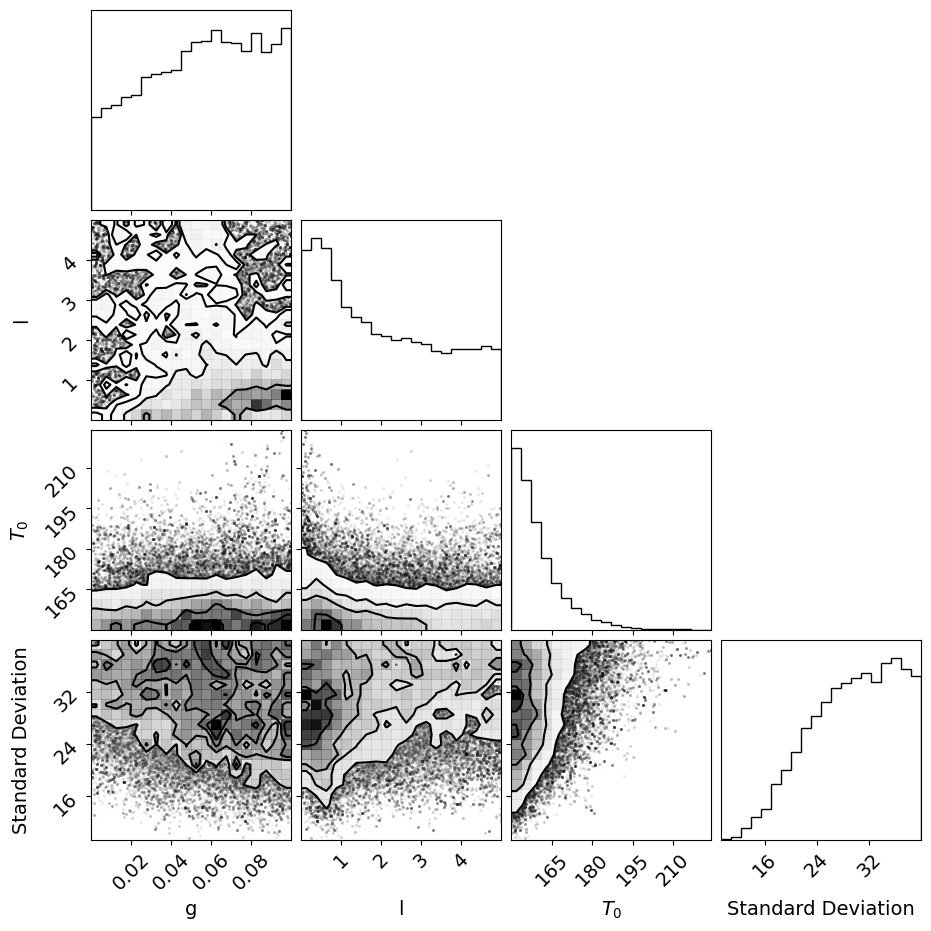

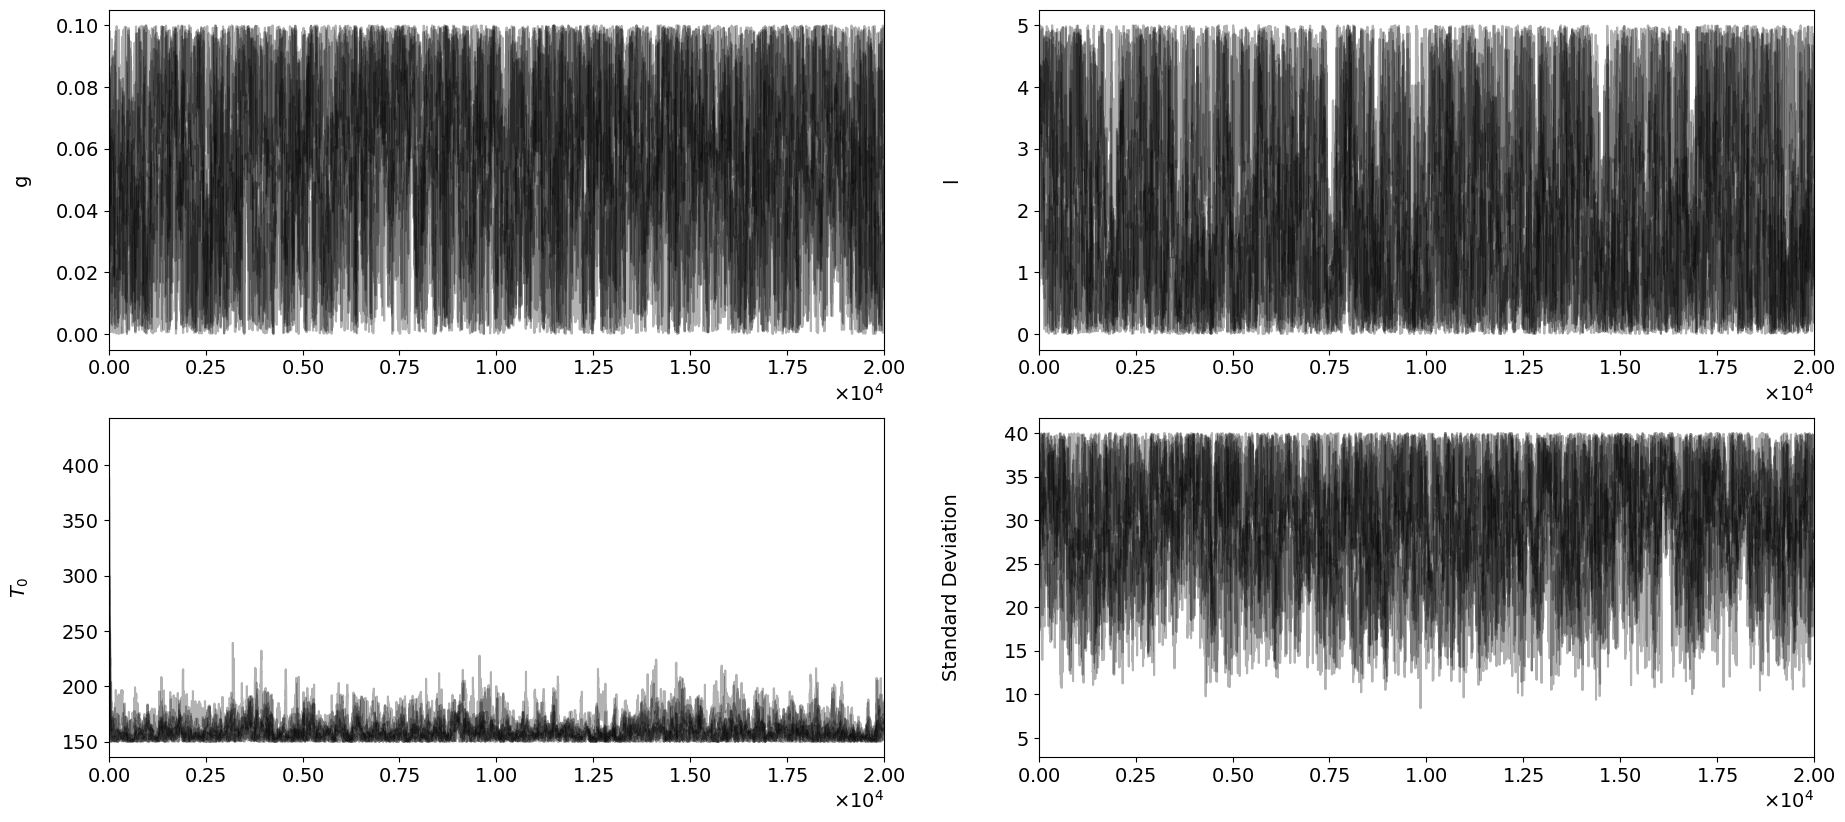

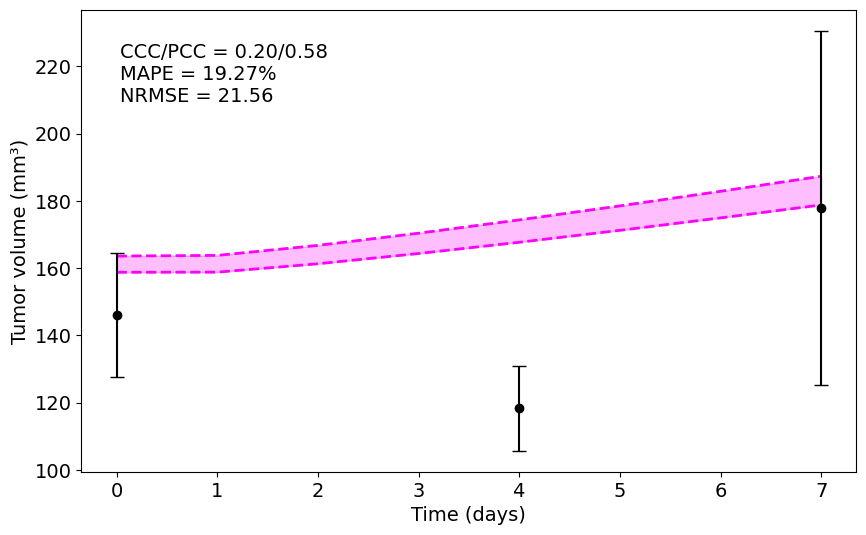

2277-R1TG9_full_G05-Pac+Carbo_1wk.txt


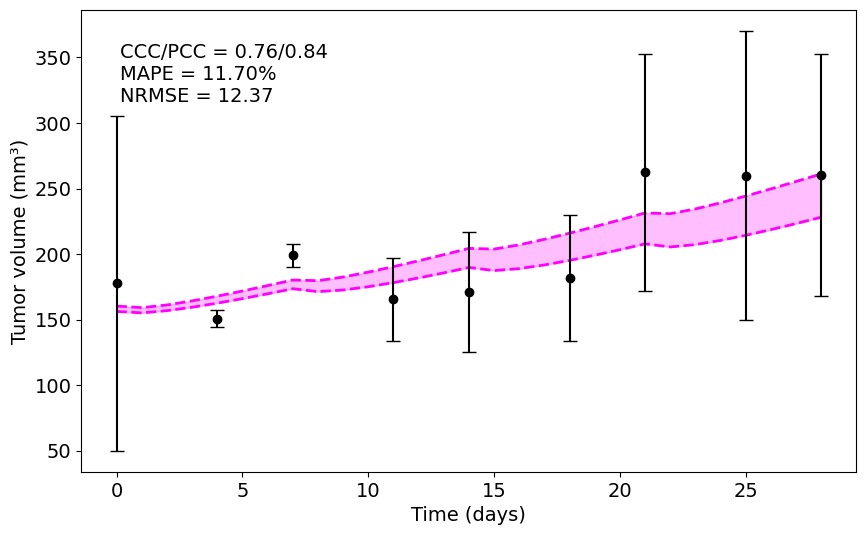

2277-R1TG9_full_G05-Pac+Carbo_1wk.txt
3204-R3TG5_full_G05-Pac+Carbo_1wk.txt
3204-R3TG5_full_G06-Pac+Carbo_4wk.txt


100%|████████████████████████████████████| 20000/20000 [02:58<00:00, 111.88it/s]


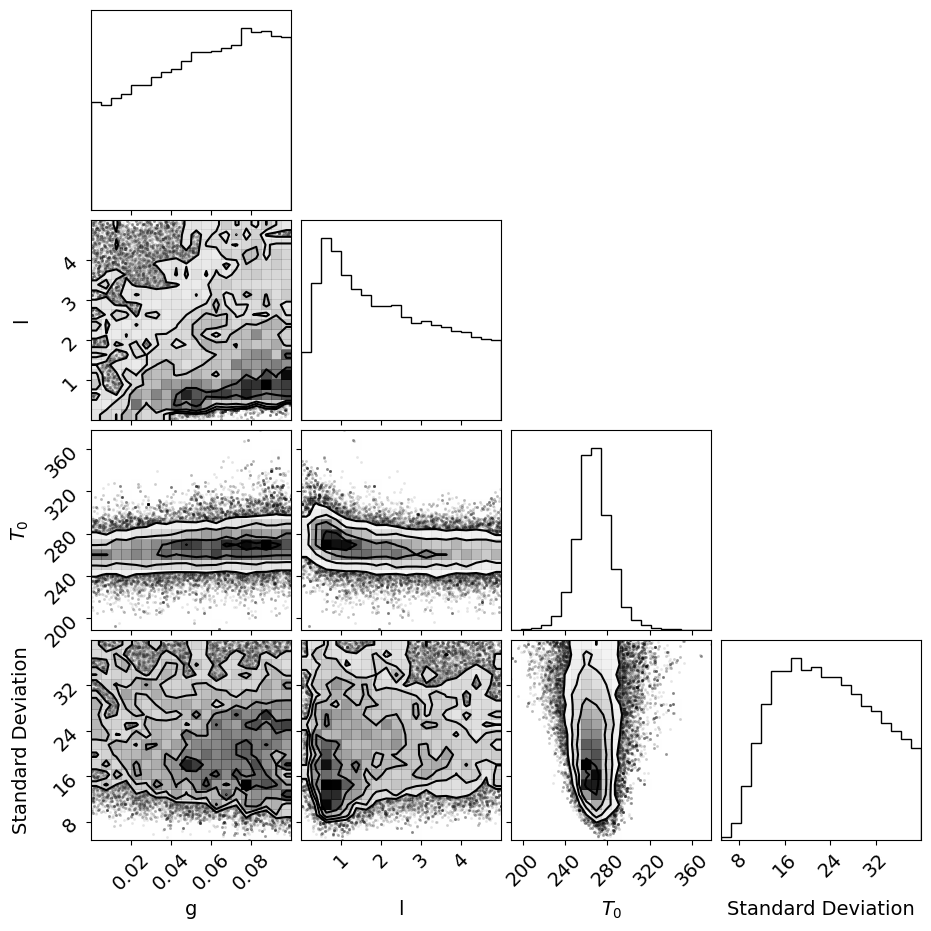

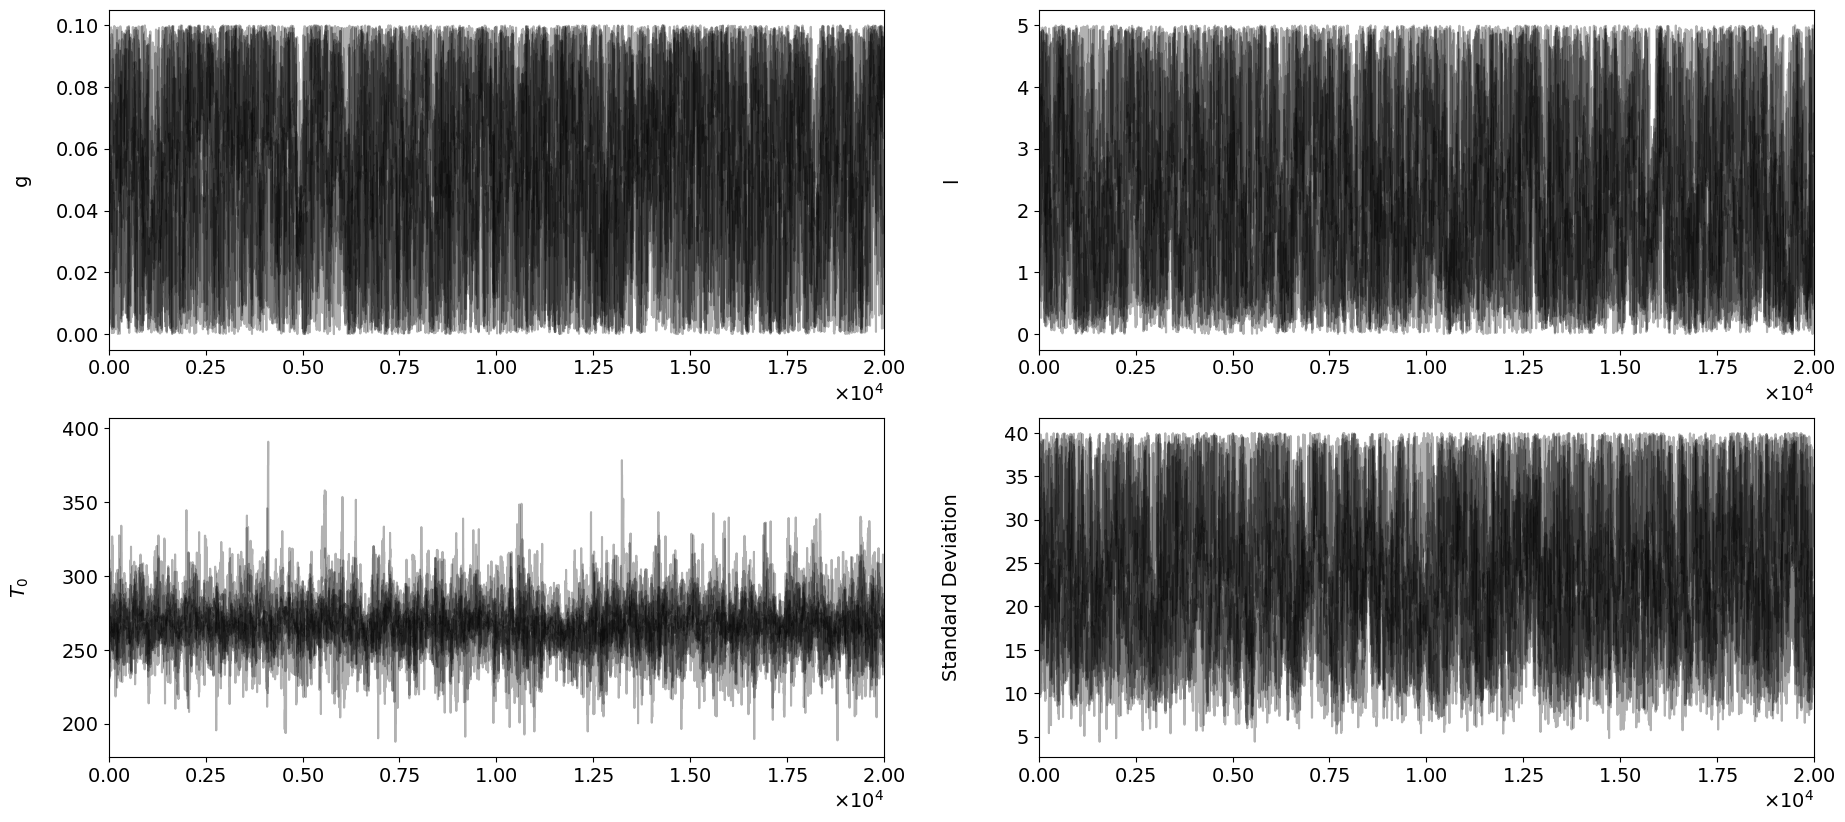

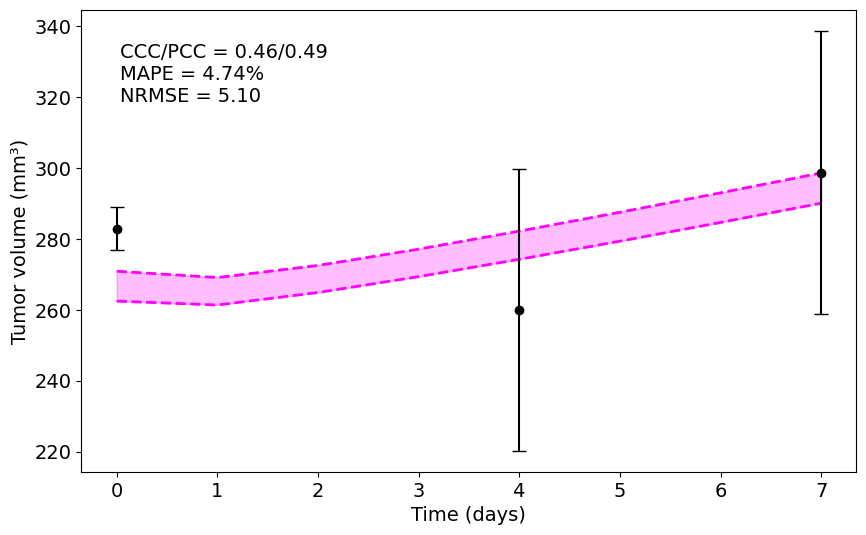

3204-R3TG5_full_G05-Pac+Carbo_1wk.txt


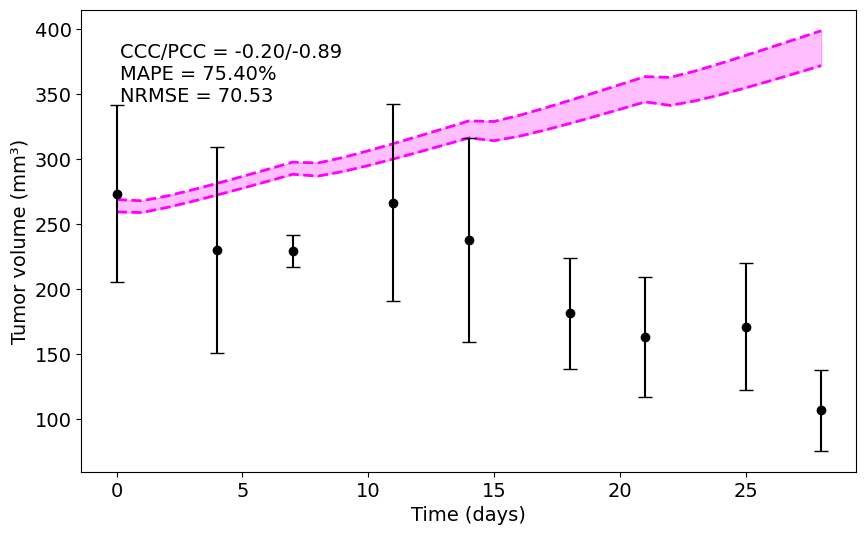

3204-R3TG5_full_G05-Pac+Carbo_1wk.txt
4849-R1TG15_full_G05-Pac+Carbo_1wk.txt
4849-R1TG15_full_G06-Pac+Carbo_4wk.txt


100%|████████████████████████████████████| 20000/20000 [03:05<00:00, 108.11it/s]


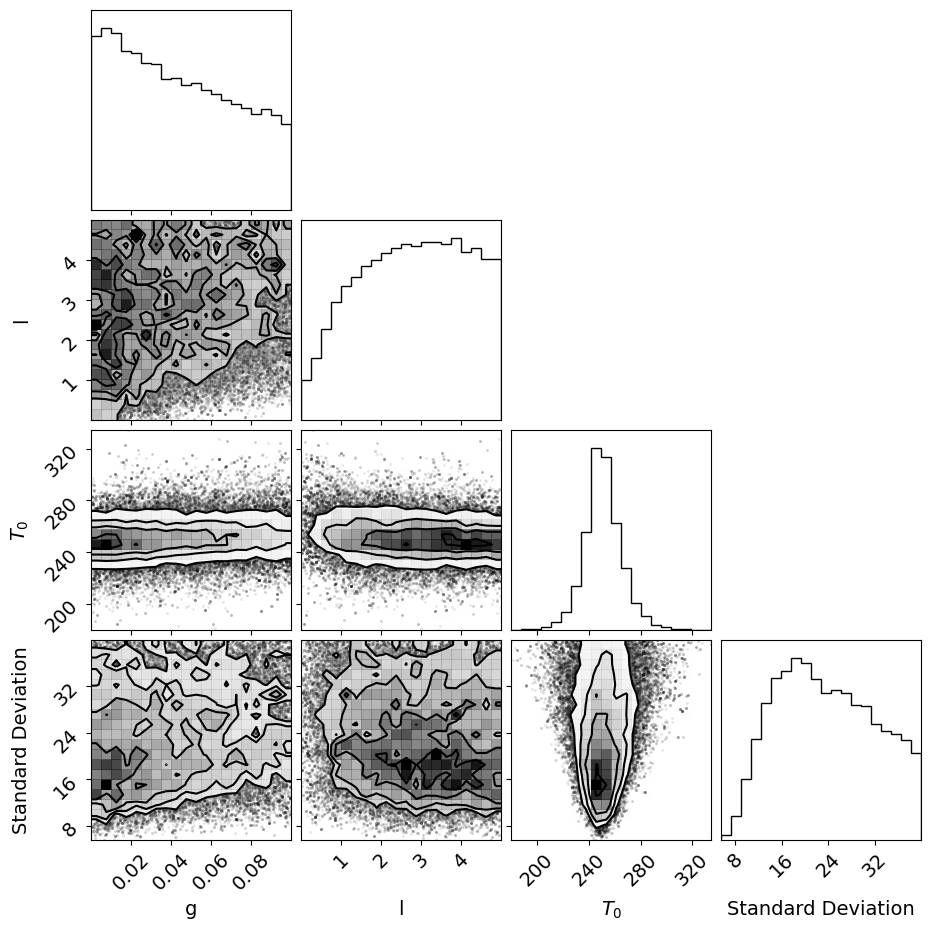

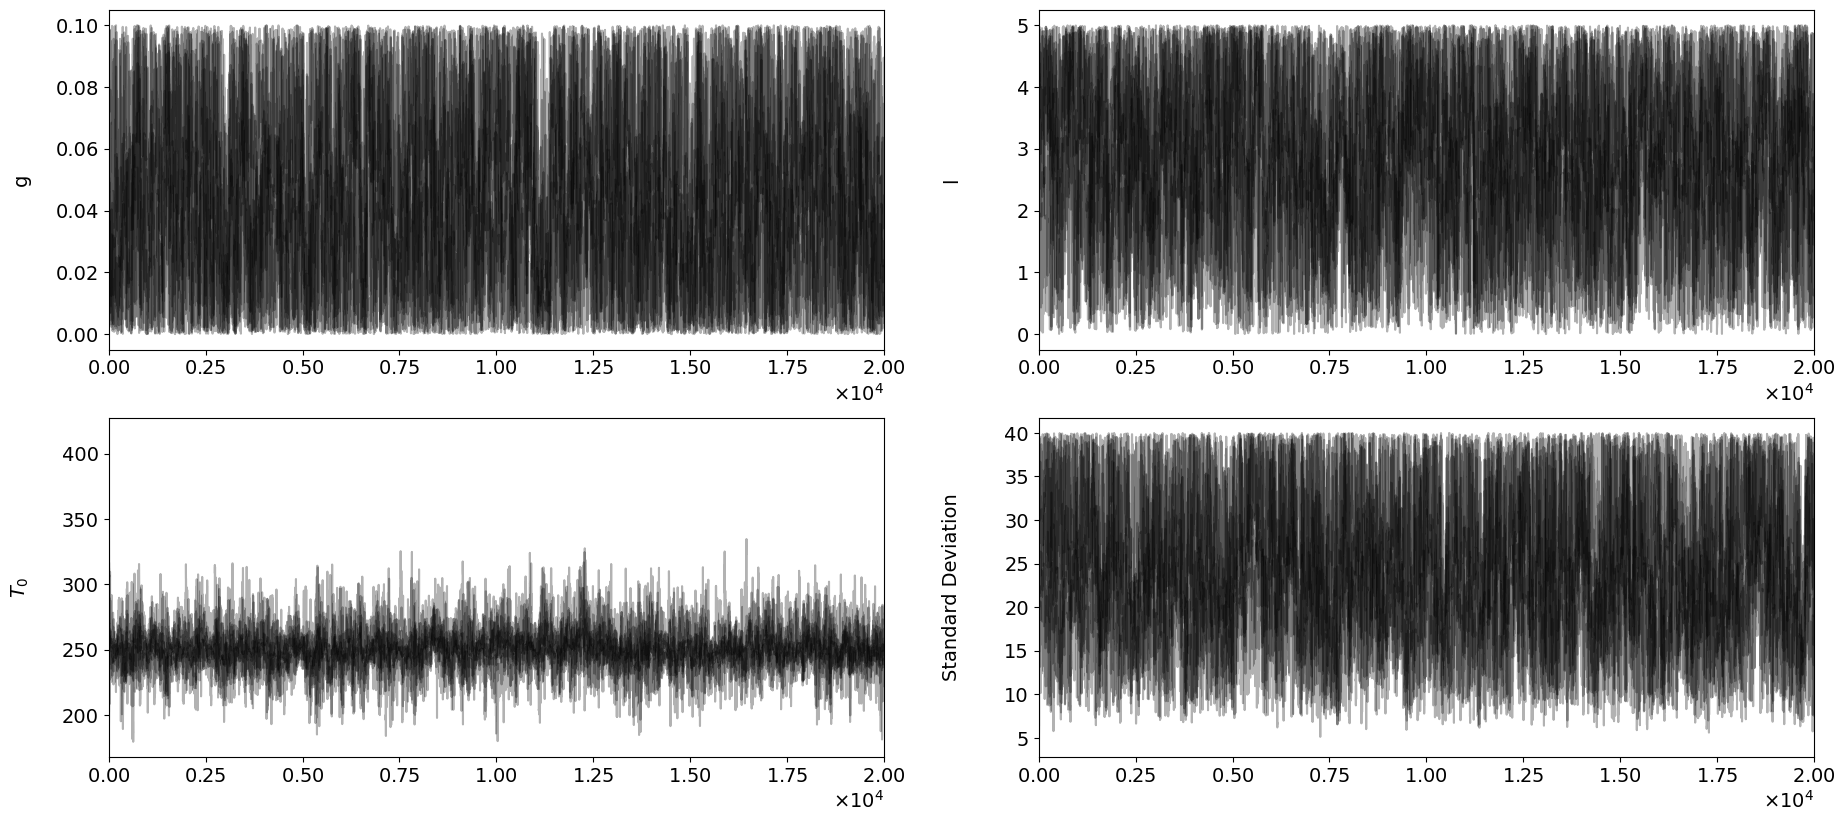

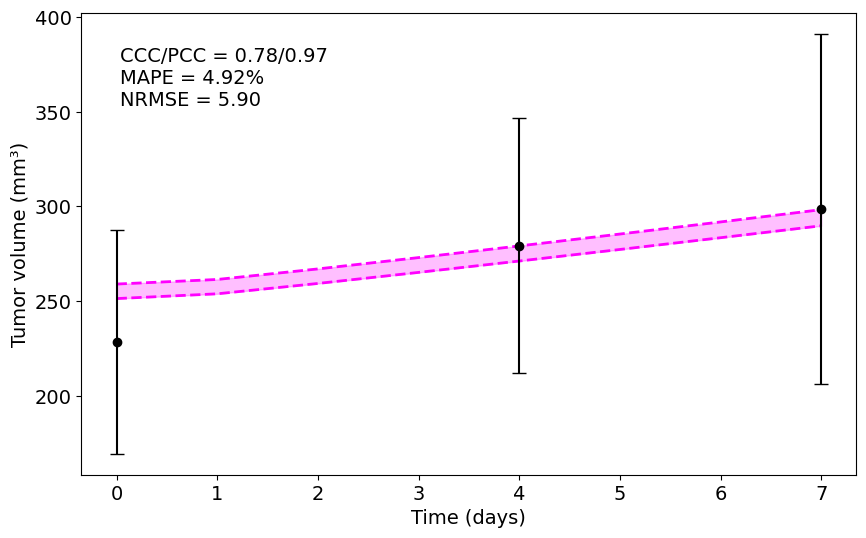

4849-R1TG15_full_G05-Pac+Carbo_1wk.txt


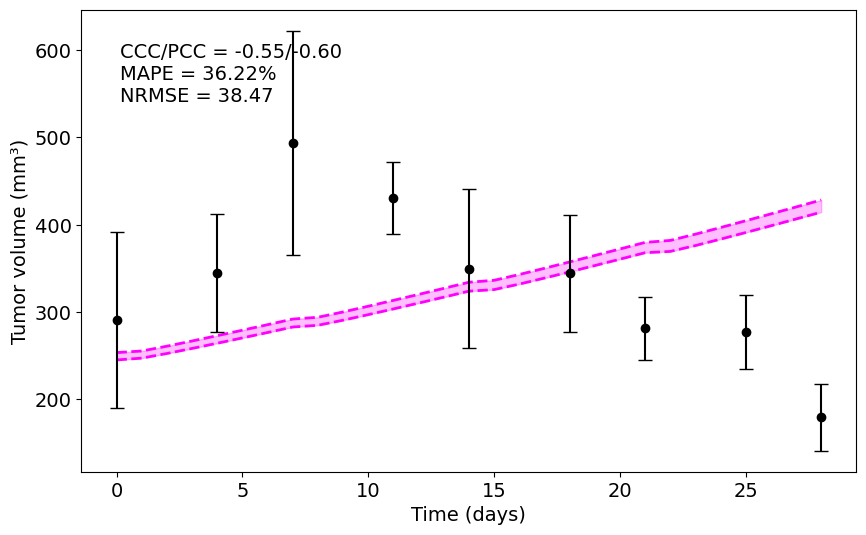

4849-R1TG15_full_G05-Pac+Carbo_1wk.txt
4913-R3TG10_full_G05-Pac+Carbo_1wk.txt
4913-R3TG10_full_G06-Pac+Carbo_4wk.txt


100%|████████████████████████████████████| 20000/20000 [02:54<00:00, 114.37it/s]


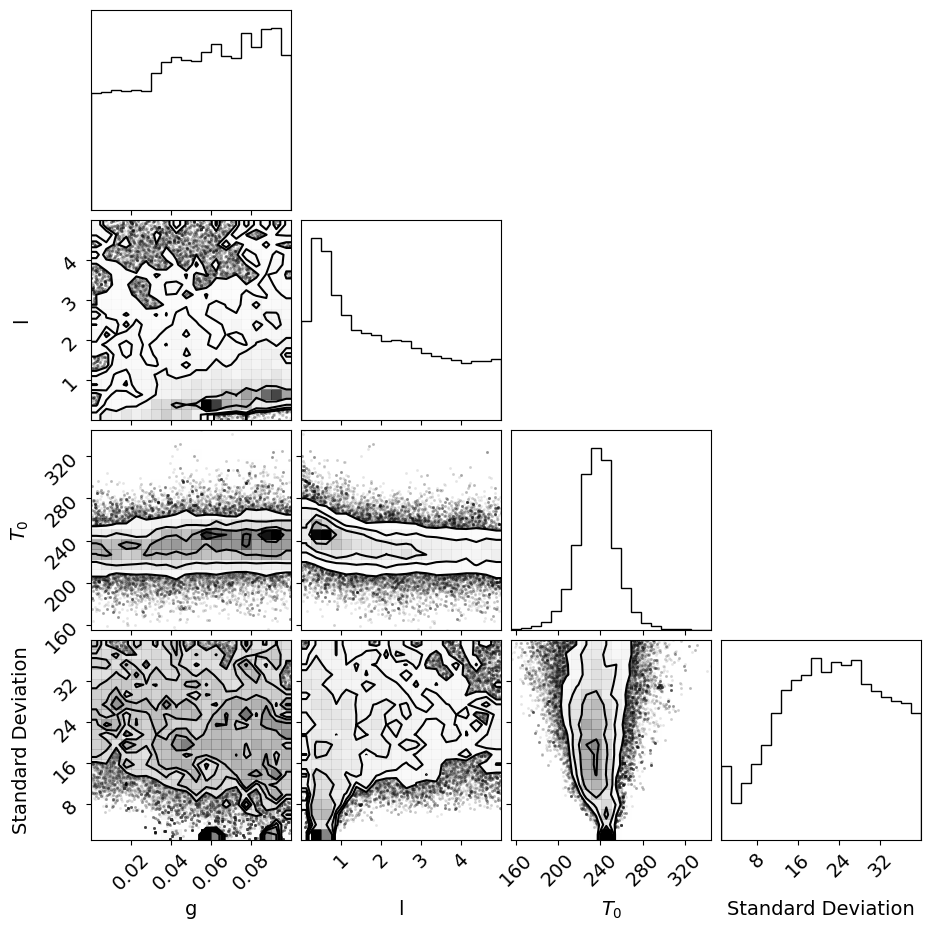

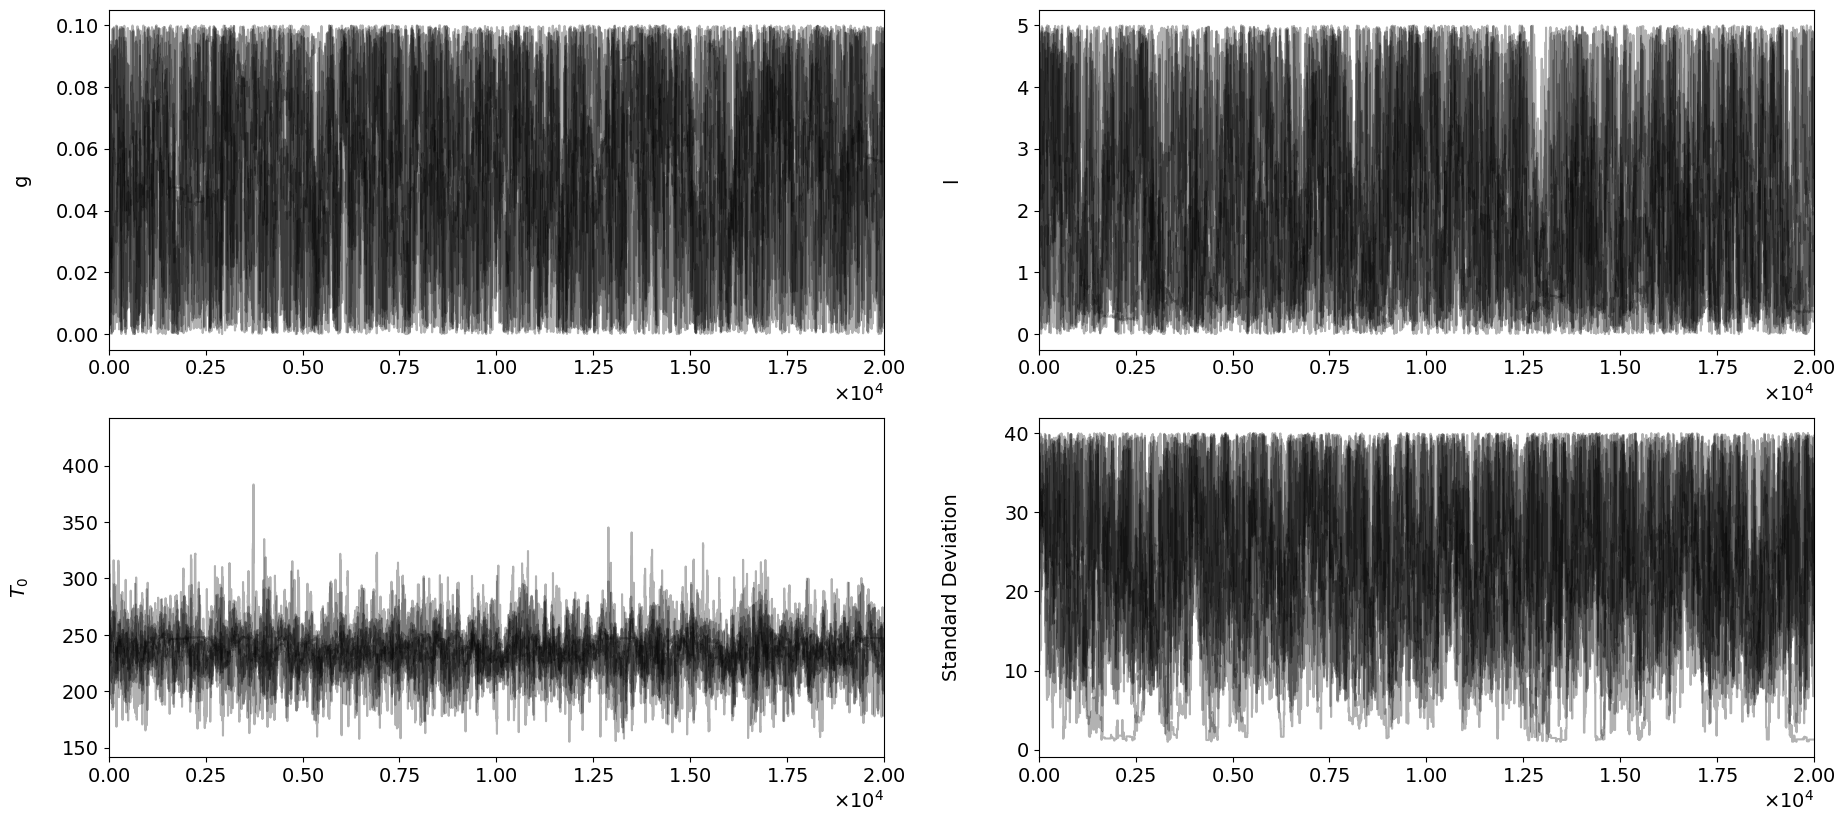

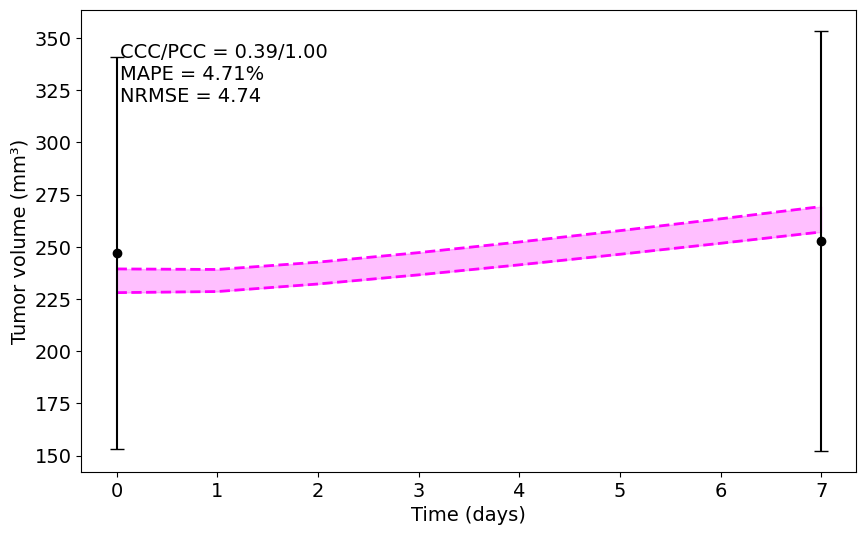

4913-R3TG10_full_G05-Pac+Carbo_1wk.txt


/var/folders/mb/db4t4c7x2b51v75ygss9ww1h0000gn/T/ipykernel_23476/2751737809.py:282: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - pred) / actual)) * 100


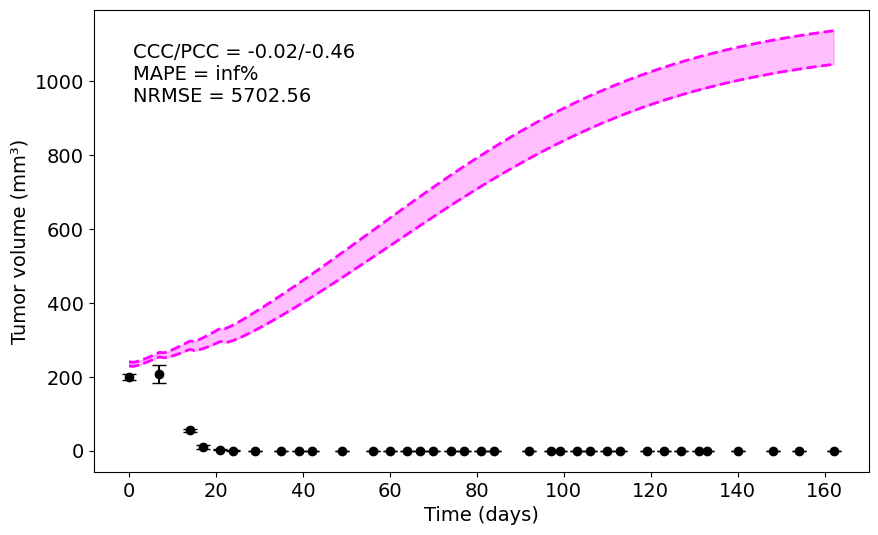

4913-R3TG10_full_G05-Pac+Carbo_1wk.txt
BRA45-R2TG8_Repeat_full_G05-Pac+Carbo_1wk.txt
BRA45-R2TG8_Repeat_full_G06-Pac+Carbo_4wk.txt


100%|████████████████████████████████████| 20000/20000 [02:40<00:00, 124.98it/s]


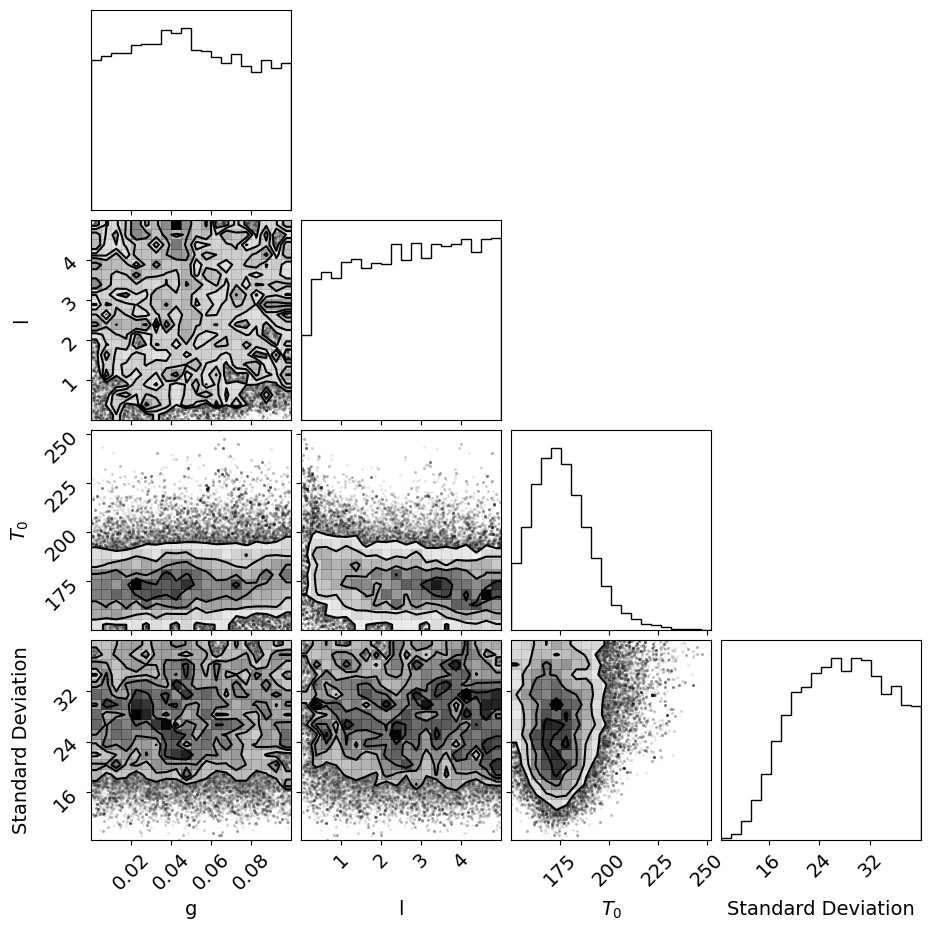

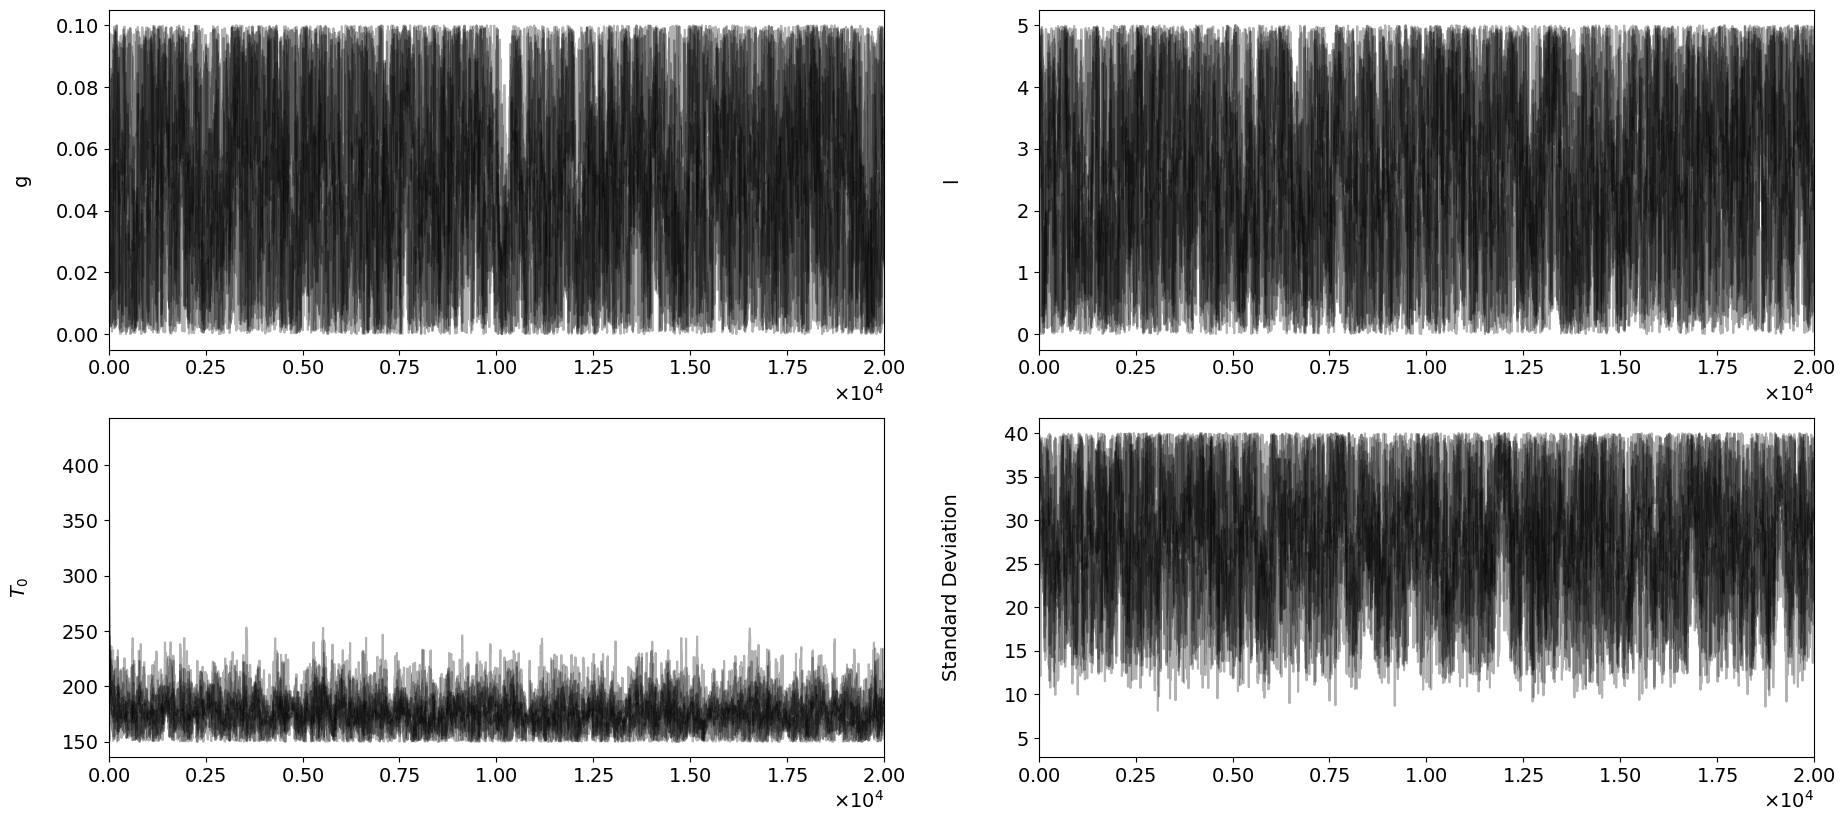

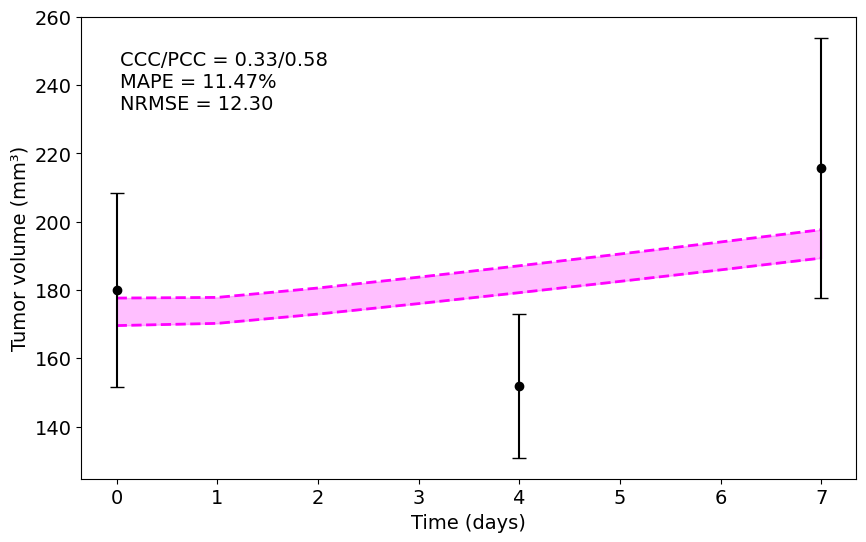

BRA45-R2TG8_Repeat_full_G05-Pac+Carbo_1wk.txt


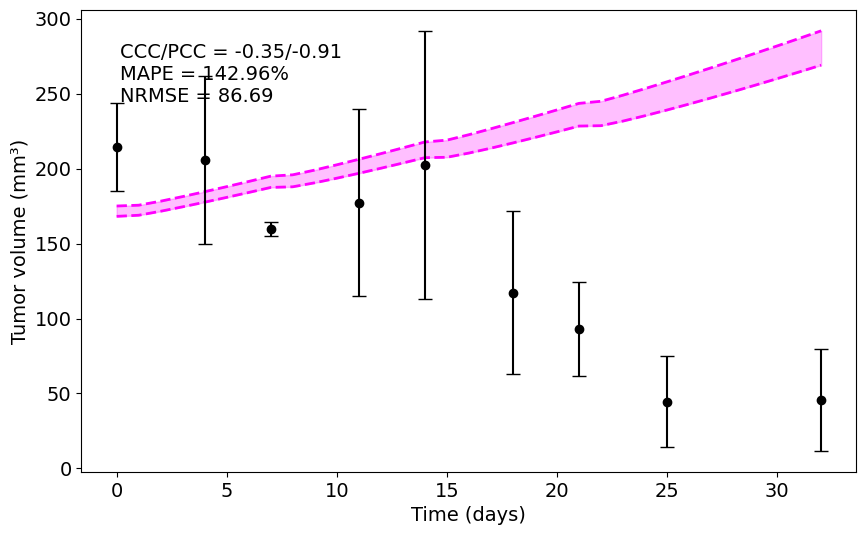

BRA45-R2TG8_Repeat_full_G05-Pac+Carbo_1wk.txt
HCI-034-TG11_Repeat_full_G05-Pac+Carbo_1wk.txt
HCI-034-TG11_Repeat_full_G06-Pac+Carbo_4wk.txt


100%|█████████████████████████████████████| 20000/20000 [05:06<00:00, 65.30it/s]


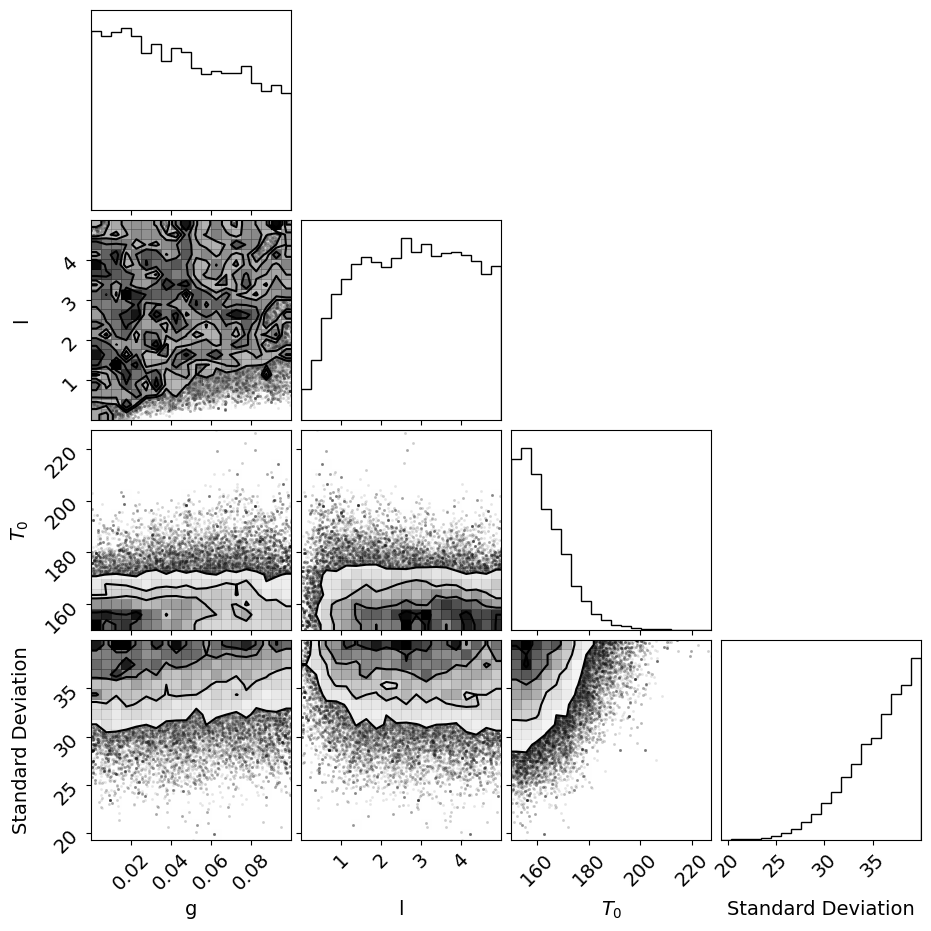

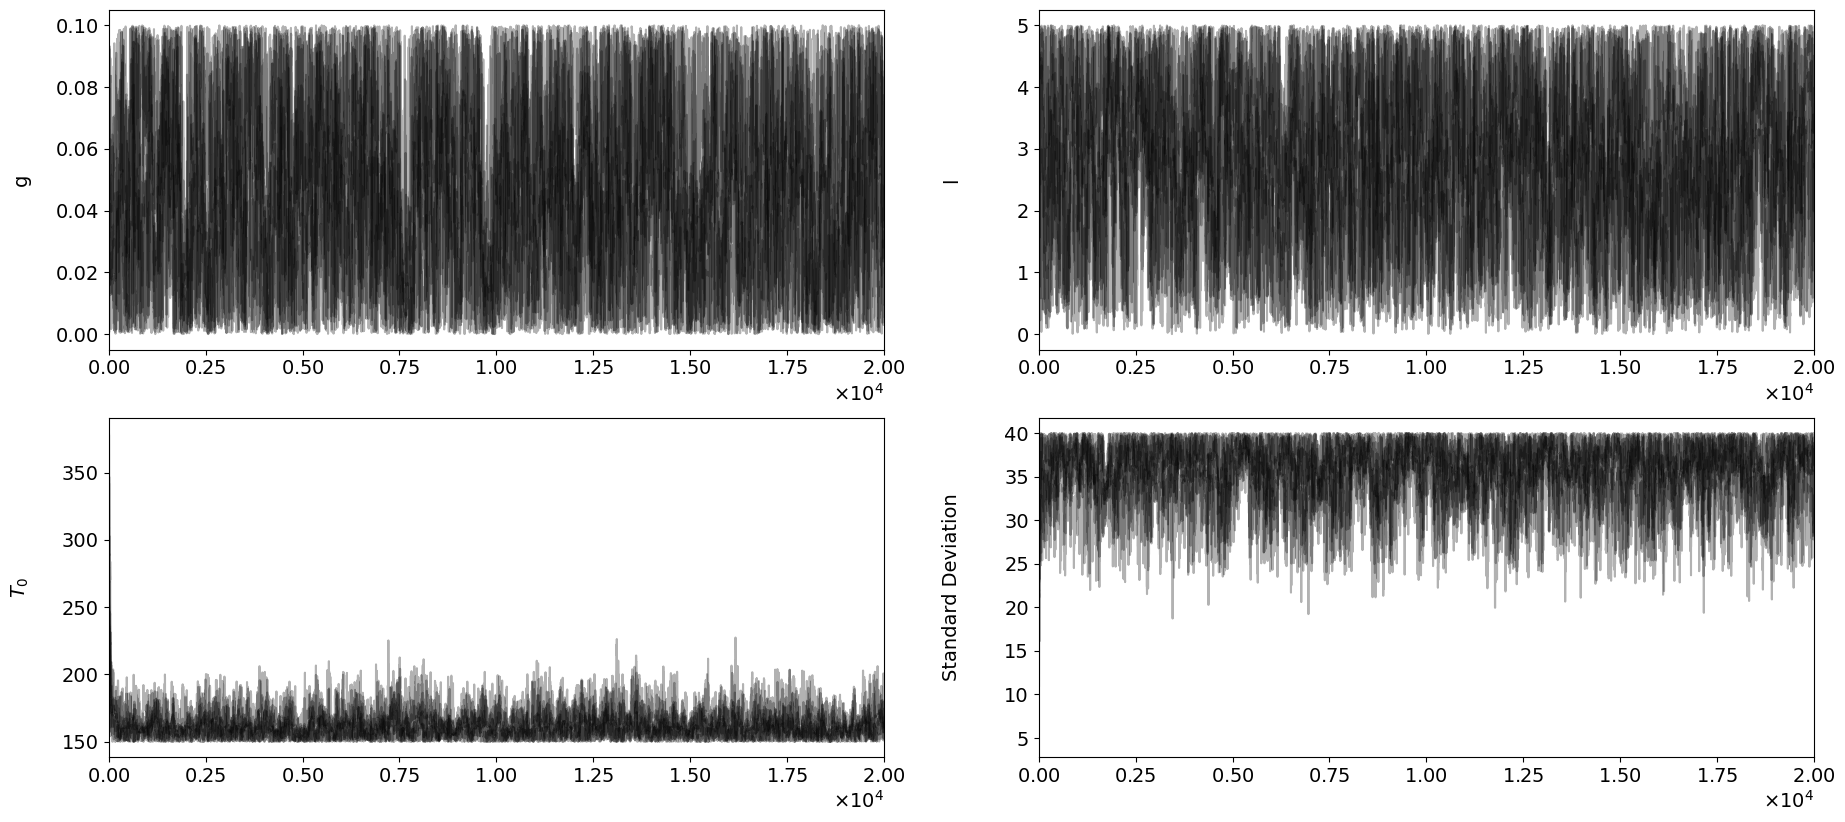

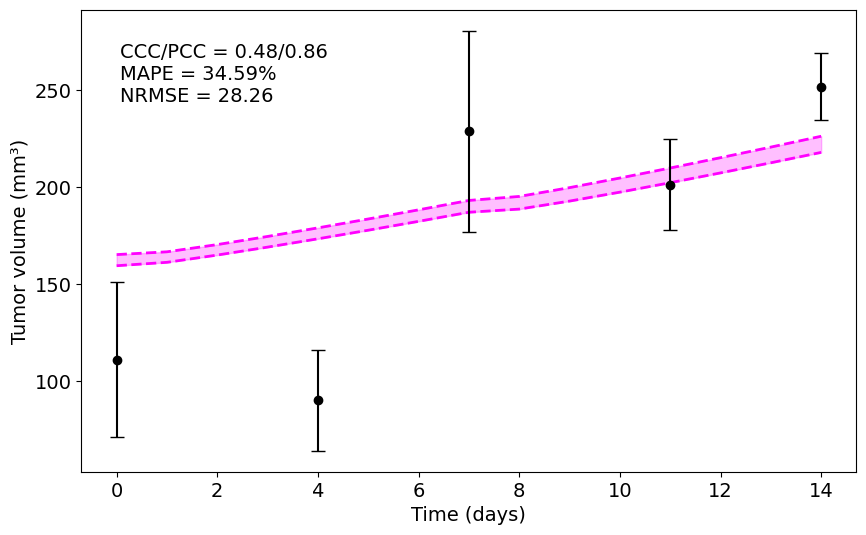

HCI-034-TG11_Repeat_full_G05-Pac+Carbo_1wk.txt


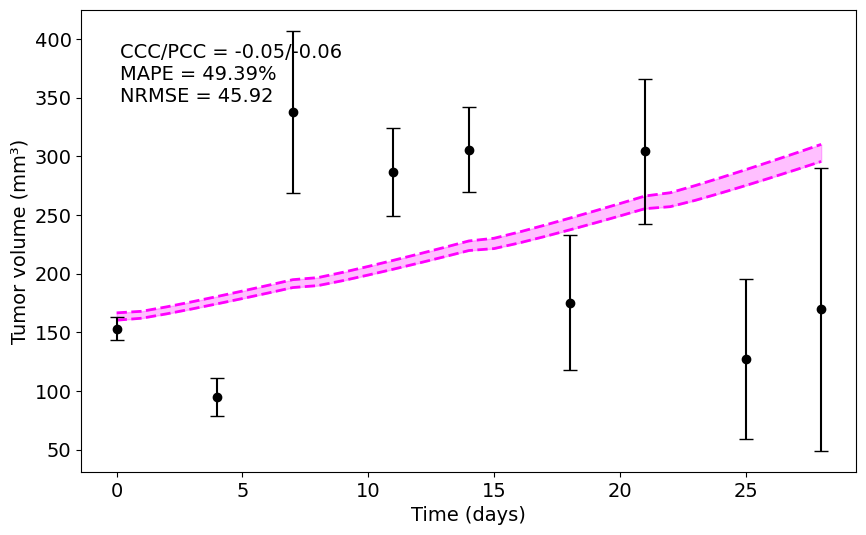

HCI-034-TG11_Repeat_full_G05-Pac+Carbo_1wk.txt


In [6]:
# Define labels for parameter names, including LaTeX formatting for some.
# This is the order of the lower and upper bounds for the parameter values
labels = ["g", "l", "$T_0$", "Standard Deviation"]

# Define lower and upper bounds for the parameter values and the number of dimensions (ndim).
l_bound = [0.0, 0, 150, 1.0]
u_bound = [0.10, 5, 450, 40]

ndim = len(l_bound)

# Determine the number of walkers as twice the number of dimensions (nwalkers).
nwalkers = 2 * ndim

# Initialize the walker positions with random values within specified bounds.
pos = np.zeros((nwalkers, ndim))
for i in range(ndim):
    pos[:, i] = np.random.uniform(low=l_bound[i], high=u_bound[i], size=nwalkers)

tuple_access_a = 0
tuple_access_b = 0
data2 = None

Treatment_Files_Data = Treatment_Files

# Untreated_Files = sorted(glob.glob('*_full_G01-Untreated.txt'))
for file_name in Week_Treatment_Files:
    print(file_name)
    data = read_data(file_name)
    if Treatment_Files_Data:
        file_name_2 = Treatment_Files_Data.pop(0)
        print(file_name_2)
        data2 = read_data(file_name_2)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(data, l_bound, u_bound, logistic_parameters[tuple_access_a][tuple_access_b], logistic_parameters[tuple_access_a][tuple_access_b+1]))
    out_cal = sampler.run_mcmc(pos, 20000, progress=True)
    samples = sampler.get_chain()
    flat_samples = sampler.get_chain(discard=int(len(samples) / 2), flat=True)
    np.savetxt(file_name + '_calibrated_chain.txt', flat_samples)
    plot_corner(flat_samples, labels,save=True)
    os.rename("corner_mouse.jpeg", file_name + '_corner_mouse.jpeg')
    plot_chain(samples, labels)
    os.rename("chains_calibration.jpeg", file_name + '_chains_calibration.jpeg')
    plot_full_solution(data, flat_samples, logistic_parameters[tuple_access_a][tuple_access_b], logistic_parameters[tuple_access_a][tuple_access_b+1])
    print(file_name)
    os.rename("solution.pdf", file_name + '_solution.pdf')
    plot_all_solution(data2, flat_samples, logistic_parameters[tuple_access_a][tuple_access_b], logistic_parameters[tuple_access_a][tuple_access_b+1])
    print(file_name)
    os.rename("solution.pdf", file_name + '_FULL_DATA_solution.pdf')
    tuple_access_a = tuple_access_a + 1
    #break

In [7]:
with open("week_treatment_aic_bic_values.txt", "w") as ic_file:
    for file_name in Week_Treatment_Files:
        tuple_access_a = 0
        tuple_access_b = 0
        print(file_name)
        data = read_data(file_name)
        max_ll = -np.infty
        best_p = None
        for p in tqdm(flat_samples):
            val = log_likelihood(p, data, logistic_parameters[tuple_access_a][tuple_access_b], logistic_parameters[tuple_access_a][tuple_access_b+1])
            if val > max_ll:
                max_ll = val
        aic = 2 * len(labels) - 2 * max_ll
        bic = np.log(len(data)) * len(labels) - 2 * max_ll
        print(file_name + " - Akaike information criterion:", aic, file=ic_file)
        print(file_name + " - Bayesian information criterion:", bic, file=ic_file)
        tuple_access_a = tuple_access_a + 1

15120-TG7_full_G05-Pac+Carbo_1wk.txt


100%|████████████████████████████████████| 80000/80000 [01:56<00:00, 688.48it/s]


2277-R1TG9_full_G05-Pac+Carbo_1wk.txt


100%|████████████████████████████████████| 80000/80000 [01:45<00:00, 760.06it/s]


3204-R3TG5_full_G05-Pac+Carbo_1wk.txt


100%|████████████████████████████████████| 80000/80000 [01:44<00:00, 764.72it/s]


4849-R1TG15_full_G05-Pac+Carbo_1wk.txt


100%|████████████████████████████████████| 80000/80000 [01:50<00:00, 722.02it/s]


4913-R3TG10_full_G05-Pac+Carbo_1wk.txt


100%|████████████████████████████████████| 80000/80000 [02:23<00:00, 555.98it/s]


BRA45-R2TG8_Repeat_full_G05-Pac+Carbo_1wk.txt


100%|████████████████████████████████████| 80000/80000 [01:45<00:00, 755.41it/s]


HCI-034-TG11_Repeat_full_G05-Pac+Carbo_1wk.txt


100%|████████████████████████████████████| 80000/80000 [03:59<00:00, 334.49it/s]


In [8]:
with open("week_treatment_p_values.txt", "w") as p_file:
    for tuple_access_a,file_name in enumerate(Week_Treatment_Files):
        #print(logistic_parameters)
        print(f"Current file: {file_name}")
        data = read_data(file_name)
        max_ll = -np.infty
        best_p = None
        #tuple_access_a = 0
        tuple_access_b = 0
        print(f"Number of samples = {len(flat_samples)}")
        print(f"Number of parameters = {len(flat_samples[0])}")
        print(f"Tuple access: ({tuple_access_a},{tuple_access_b})")
        for p in tqdm(flat_samples):
            val = log_likelihood(p, data, logistic_parameters[tuple_access_a][tuple_access_b], logistic_parameters[tuple_access_a][tuple_access_b+1])
            if val > max_ll:
                max_ll = val
                best_p = p
        print(file_name + "_treatment_par", best_p, file = p_file)

Current file: 15120-TG7_full_G05-Pac+Carbo_1wk.txt
Number of samples = 80000
Number of parameters = 4
Tuple access: (0,0)


100%|████████████████████████████████████| 80000/80000 [02:09<00:00, 615.55it/s]


Current file: 2277-R1TG9_full_G05-Pac+Carbo_1wk.txt
Number of samples = 80000
Number of parameters = 4
Tuple access: (1,0)


100%|████████████████████████████████████| 80000/80000 [01:43<00:00, 776.58it/s]


Current file: 3204-R3TG5_full_G05-Pac+Carbo_1wk.txt
Number of samples = 80000
Number of parameters = 4
Tuple access: (2,0)


100%|████████████████████████████████████| 80000/80000 [01:46<00:00, 751.87it/s]


Current file: 4849-R1TG15_full_G05-Pac+Carbo_1wk.txt
Number of samples = 80000
Number of parameters = 4
Tuple access: (3,0)


100%|████████████████████████████████████| 80000/80000 [01:41<00:00, 787.30it/s]


Current file: 4913-R3TG10_full_G05-Pac+Carbo_1wk.txt
Number of samples = 80000
Number of parameters = 4
Tuple access: (4,0)


100%|████████████████████████████████████| 80000/80000 [01:49<00:00, 731.25it/s]


Current file: BRA45-R2TG8_Repeat_full_G05-Pac+Carbo_1wk.txt
Number of samples = 80000
Number of parameters = 4
Tuple access: (5,0)


100%|████████████████████████████████████| 80000/80000 [01:45<00:00, 761.36it/s]


Current file: HCI-034-TG11_Repeat_full_G05-Pac+Carbo_1wk.txt
Number of samples = 80000
Number of parameters = 4
Tuple access: (6,0)


100%|████████████████████████████████████| 80000/80000 [03:36<00:00, 369.18it/s]
